In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from ugradiolab.analysis import SpectrumLite


def psd_without_dc(spec):
    vals = np.array(spec.psd, dtype=float, copy=True)
    i0 = spec.bin_at(spec.center_freq)
    lo = max(0, i0)
    hi = min(vals.size, i0 + 1)
    vals[lo:hi] = np.nan
    return vals


/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
def load_or_process(data_dir: str, exclude_fn=None) -> list[SpectrumLite]:
    """Load pre-processed SpectrumLite .npz files if available, else compute from raw Records.

    Processed files are cached in a sibling ``<dir>_lite/`` directory so that
    subsequent runs skip the (potentially expensive) FFT step.

    Parameters
    ----------
    data_dir : str
        Directory containing raw Record .npz files.
    exclude_fn : callable, optional
        Paths for which ``exclude_fn(path)`` is True are skipped during processing.
    """
    data_dir = os.fspath(data_dir)
    lite_dir = os.path.join(os.path.dirname(data_dir), os.path.basename(data_dir) + '_lite')

    if os.path.isdir(lite_dir):
        lite_files = sorted(
            os.path.join(lite_dir, name)
            for name in os.listdir(lite_dir)
            if name.endswith('.npz')
        )
        if lite_files:
            print(f'Loading pre-processed SpectrumLite from {lite_dir}')
            return [SpectrumLite.load(p) for p in lite_files]

    print(f'Processing raw data from {data_dir} → {lite_dir}')
    os.makedirs(lite_dir, exist_ok=True)

    spectra = []
    raw_files = sorted(
        os.path.join(data_dir, name)
        for name in os.listdir(data_dir)
        if name.endswith('.npz')
    )
    for p in raw_files:
        if exclude_fn is not None and exclude_fn(p):
            continue
        sl = SpectrumLite.from_data(p)
        sl.save(os.path.join(lite_dir, os.path.basename(p)))
        spectra.append(sl)
    return spectra


In [3]:
DATA_ROOT = os.path.join('..', '..', 'data', 'lab02')
DATA_DIR = os.path.join(DATA_ROOT, 'noise')

obs_spectra_raw = load_or_process(DATA_DIR)
obs_spectra_raw.sort(key=lambda s: s.nblocks)
obs_spectra = [(s.nblocks, s) for s in obs_spectra_raw]

for n, spec in obs_spectra:
    print(f'  nblocks={n:>5d}  total_power={spec.total_power:.4f}')


Loading pre-processed SpectrumLite from ../../data/lab02/noise_lite
  nblocks=    2  total_power=26.2846
  nblocks=    4  total_power=26.7110
  nblocks=    8  total_power=28.3048
  nblocks=   16  total_power=30.3308
  nblocks=   32  total_power=31.2703
  nblocks=   64  total_power=31.6592
  nblocks=  128  total_power=31.7838
  nblocks=  256  total_power=31.8226
  nblocks=  512  total_power=31.8113
  nblocks= 1024  total_power=31.5662
  nblocks= 2048  total_power=31.2793
  nblocks= 4096  total_power=30.4895


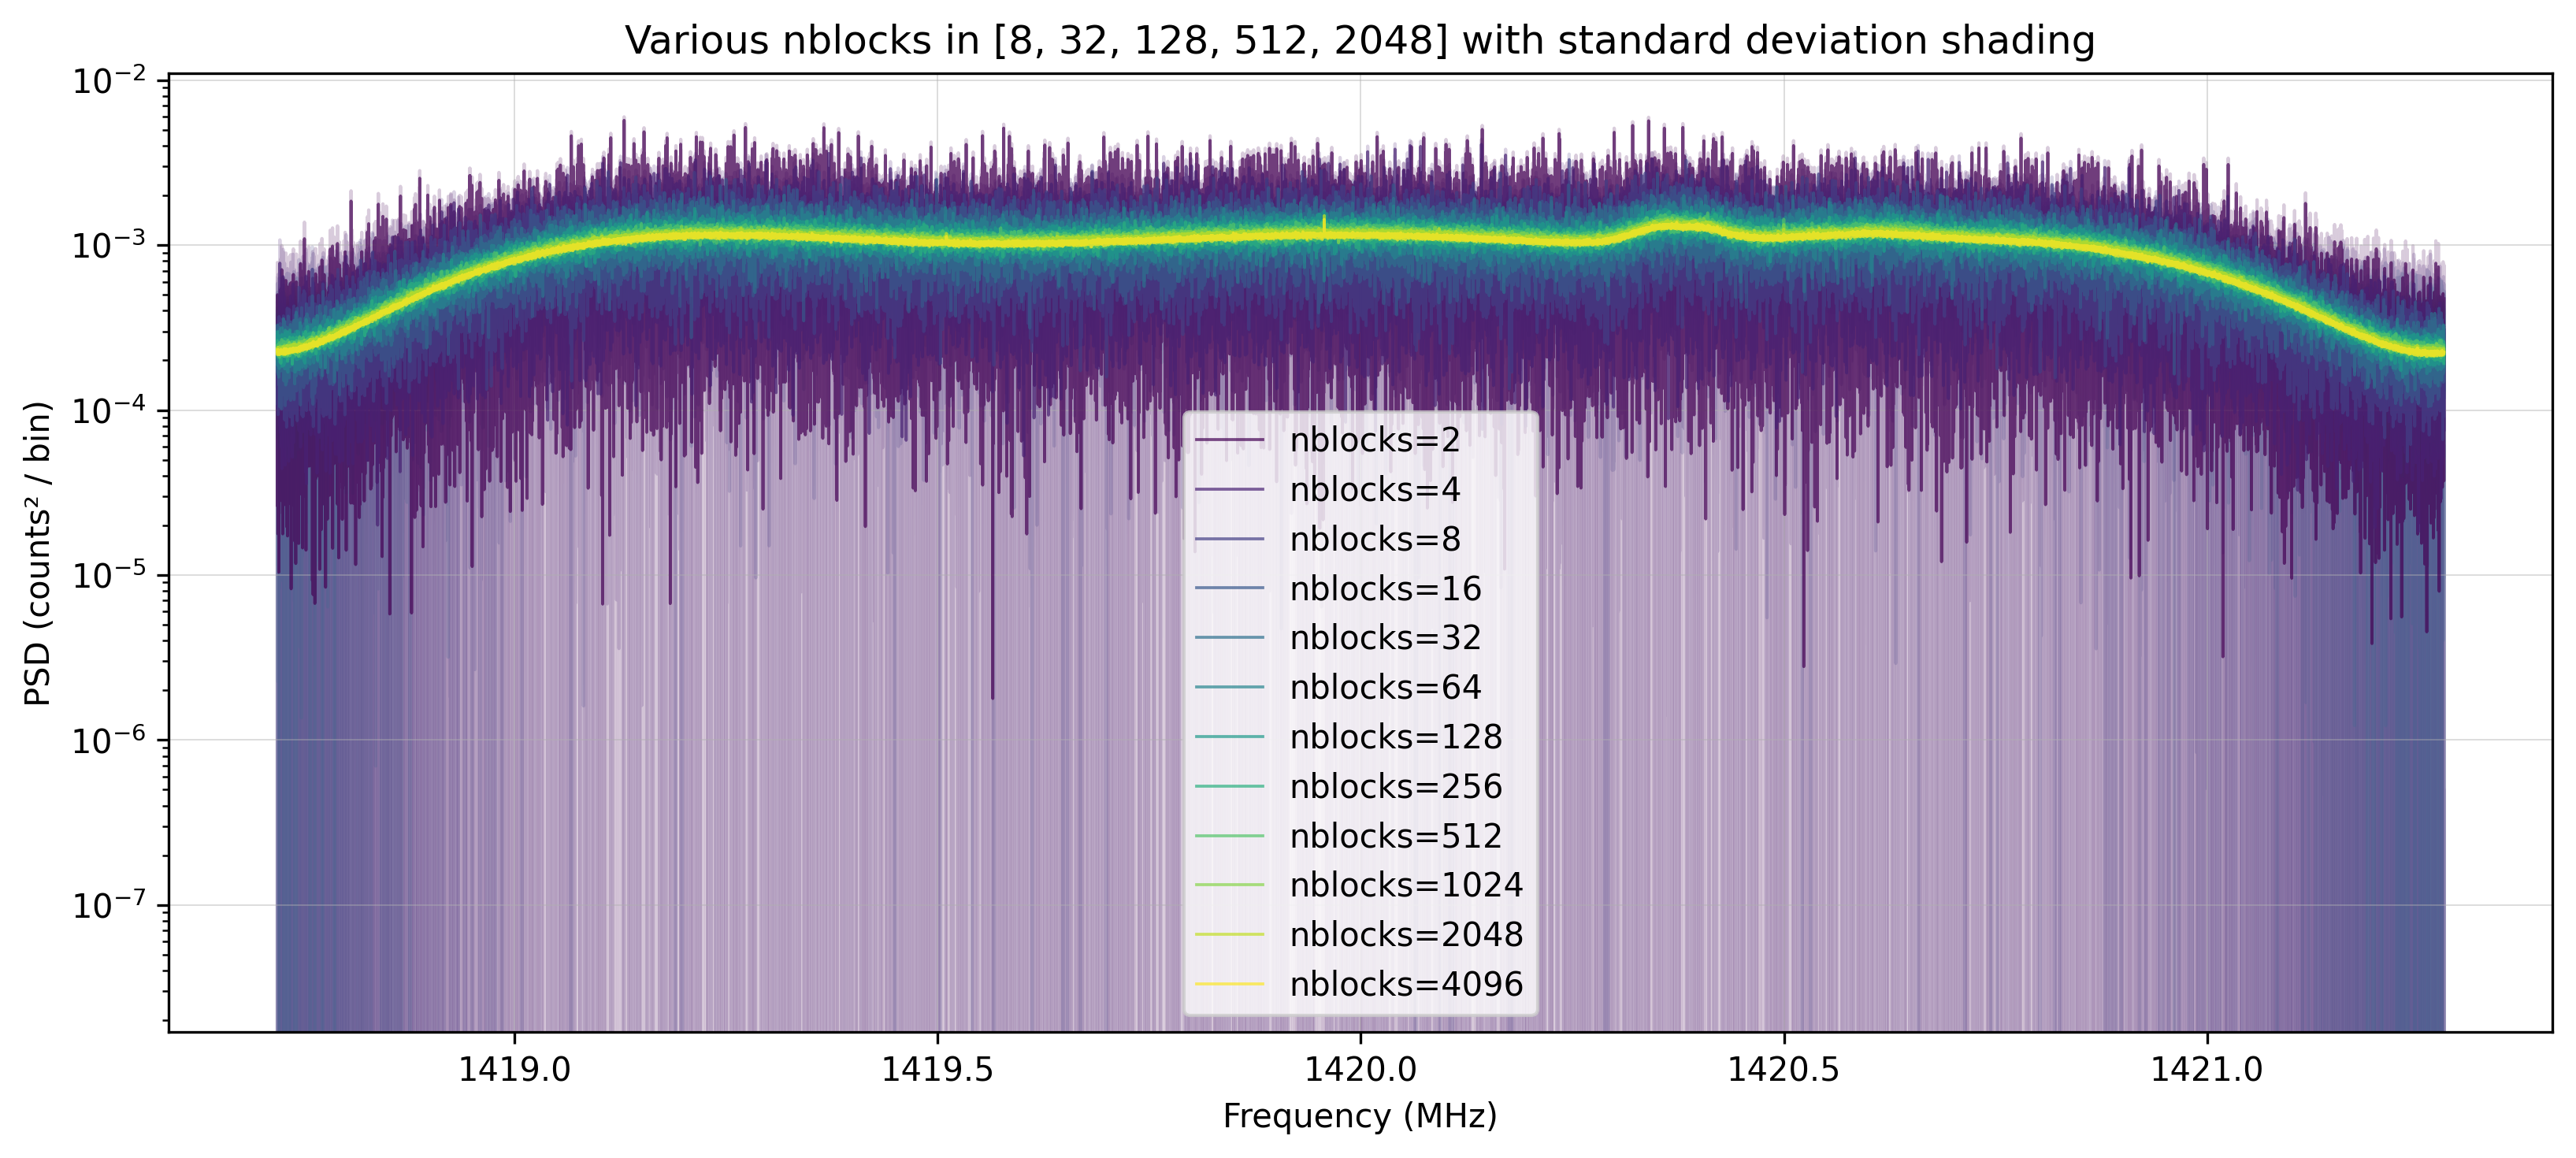

In [4]:
cmap = plt.colormaps['viridis']
colors = [cmap(i / max(len(obs_spectra) - 1, 1)) for i in range(len(obs_spectra))]

fig, ax = plt.subplots(figsize=(11, 5), dpi=300)

for (n, spec), color in zip(obs_spectra, colors):
    psd = psd_without_dc(spec)
    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std,
                    color=color, alpha=0.2)
    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9, alpha=0.7, label=f'nblocks={n}')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts² / bin)')
ax.set_title('Various nblocks in [8, 32, 128, 512, 2048] with standard deviation shading')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()


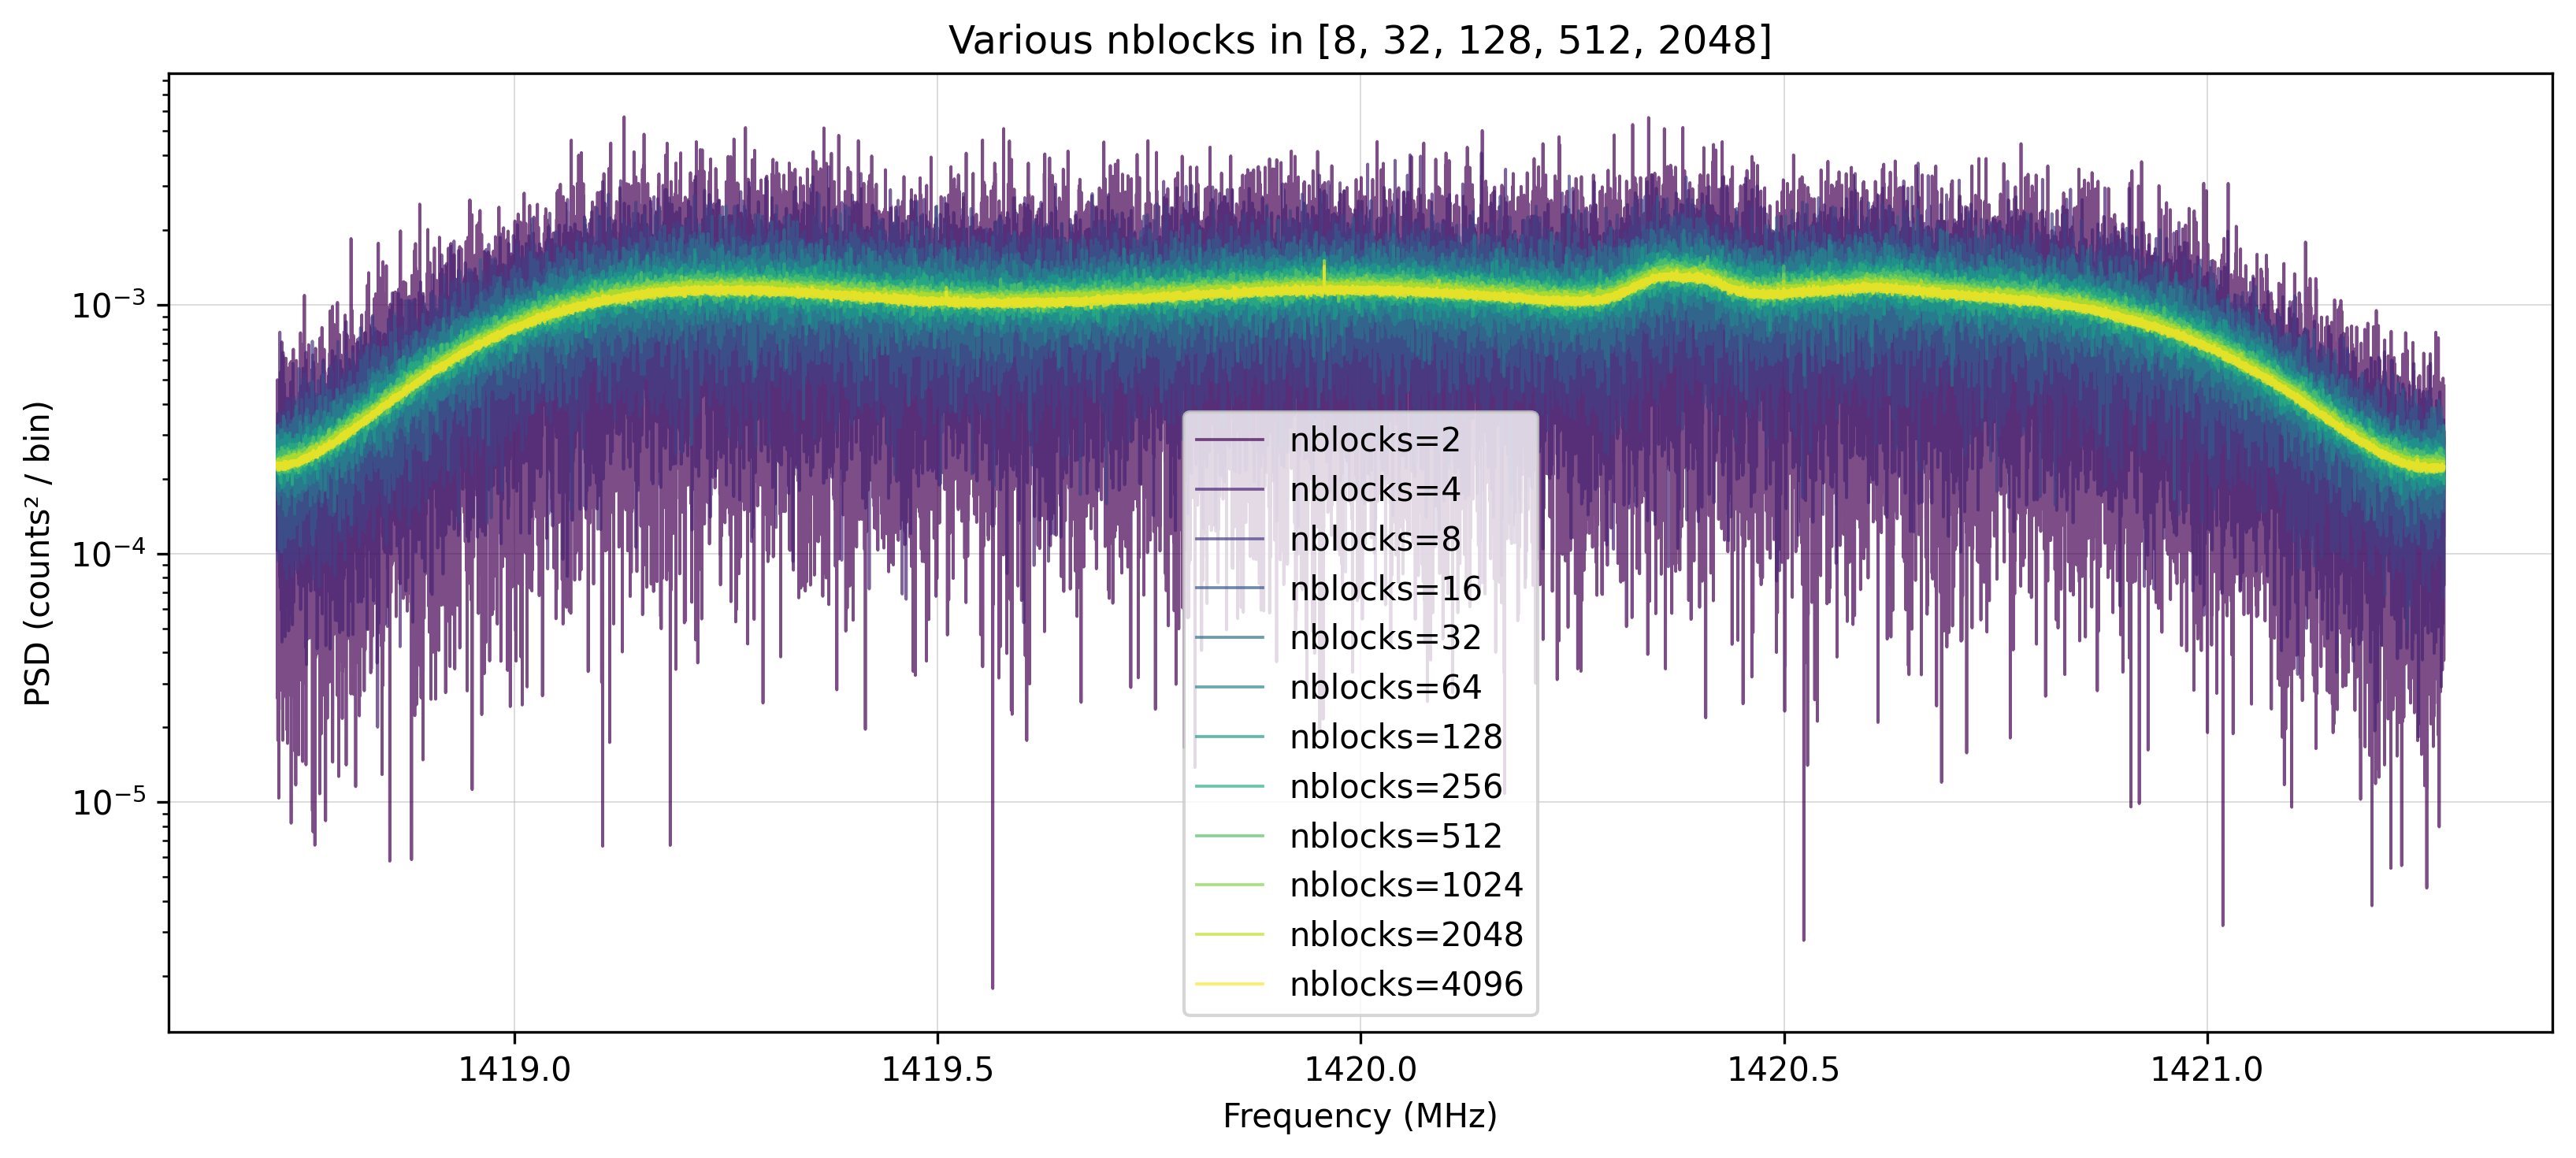

In [5]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=300)

for (n, spec), color in zip(obs_spectra, colors):
    psd = psd_without_dc(spec)
    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9, alpha=0.7, label=f'nblocks={n}')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts² / bin)')
ax.set_title('Various nblocks in [8, 32, 128, 512, 2048]')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()


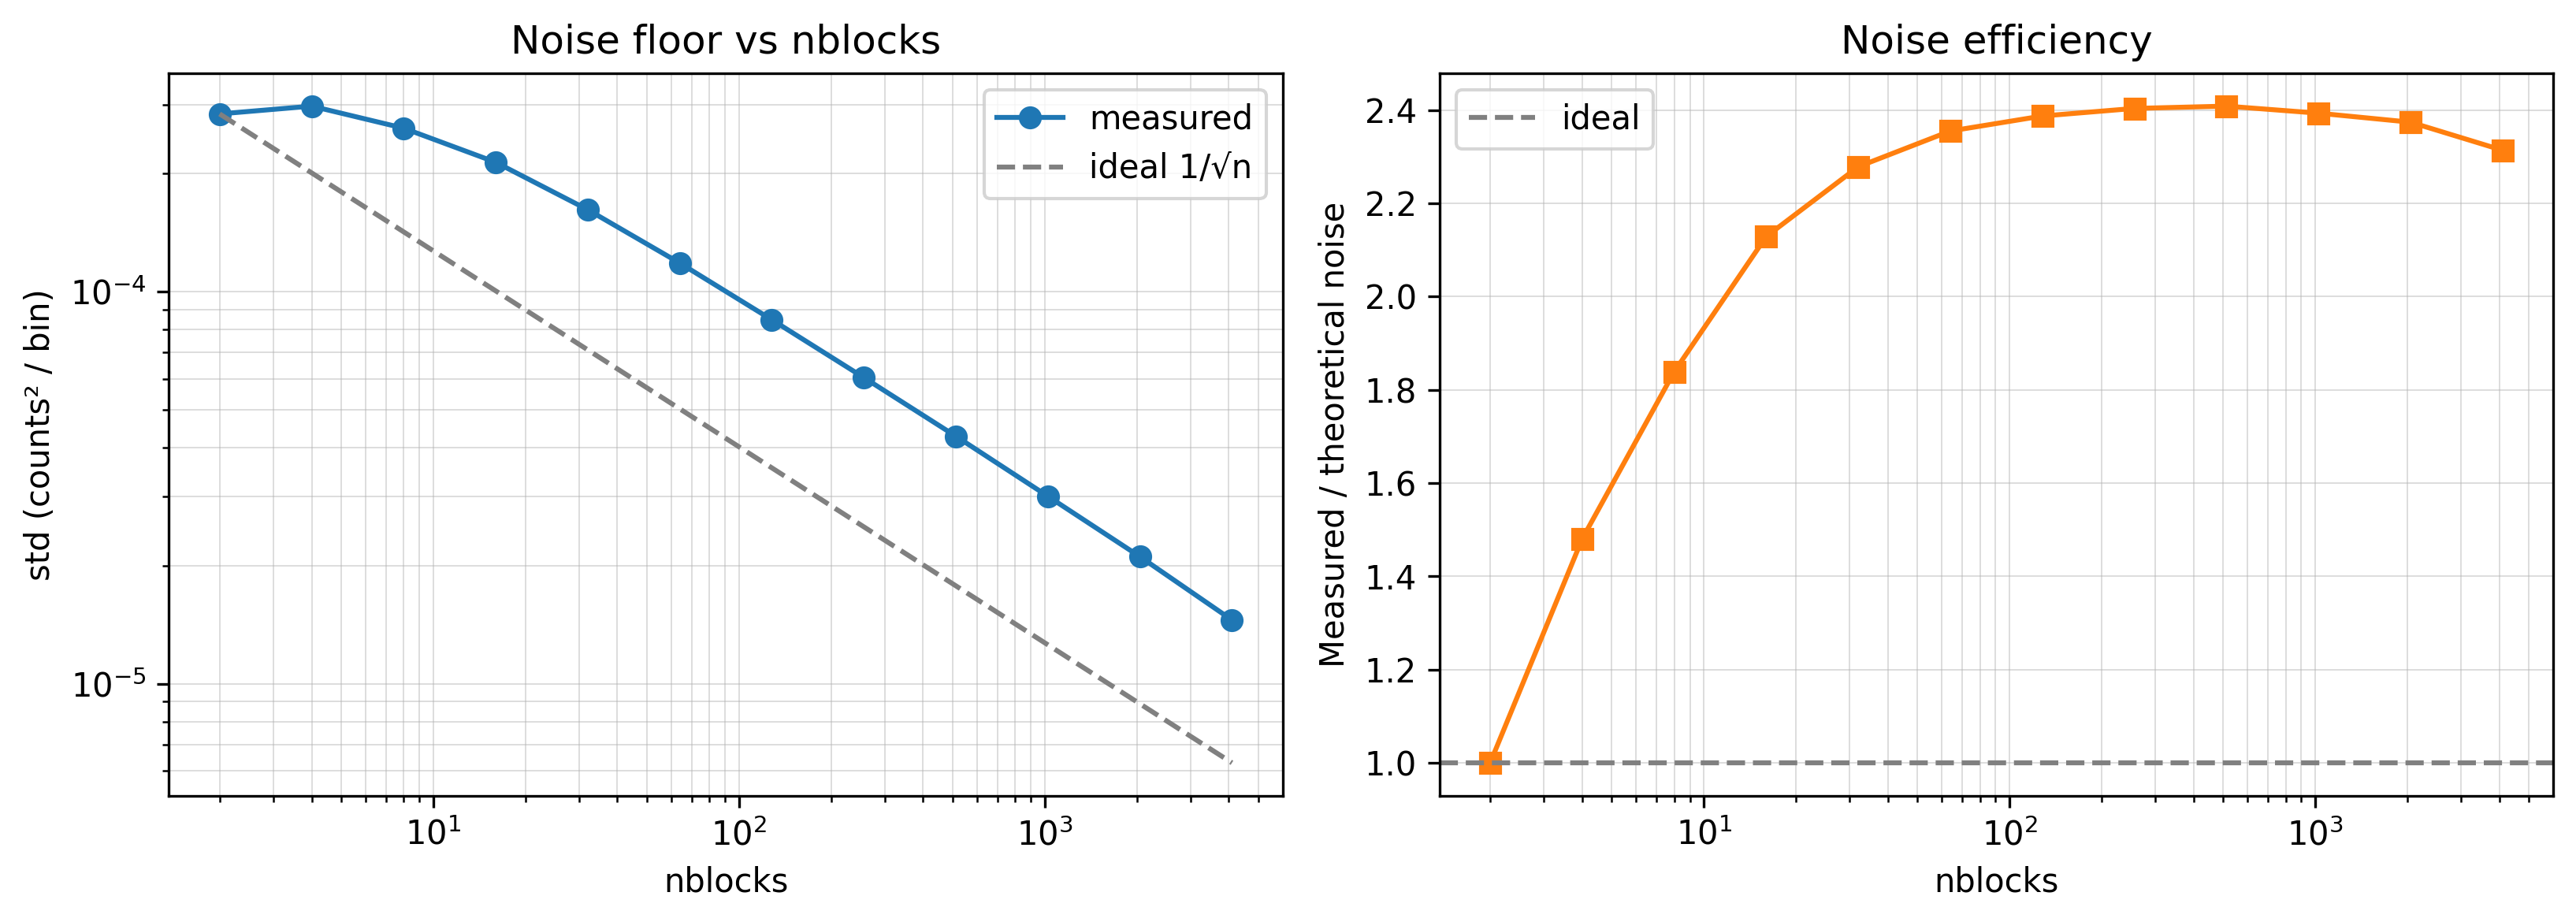

  nblocks=    2  noise=0.00028  efficiency=1.000
  nblocks=    4  noise=0.00030  efficiency=1.480
  nblocks=    8  noise=0.00026  efficiency=1.839
  nblocks=   16  noise=0.00021  efficiency=2.129
  nblocks=   32  noise=0.00016  efficiency=2.278
  nblocks=   64  noise=0.00012  efficiency=2.355
  nblocks=  128  noise=0.00008  efficiency=2.387
  nblocks=  256  noise=0.00006  efficiency=2.403
  nblocks=  512  noise=0.00004  efficiency=2.408
  nblocks= 1024  noise=0.00003  efficiency=2.393
  nblocks= 2048  noise=0.00002  efficiency=2.374
  nblocks= 4096  noise=0.00001  efficiency=2.314


In [6]:
ns    = np.array([n for n, _ in obs_spectra])
noise = np.array([spec.std for _, spec in obs_spectra])

theoretical = noise[0] / np.sqrt(ns / ns[0])
efficiency  = noise / theoretical

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), dpi=300)

ax1.loglog(ns, noise,       'o-', label='measured')
ax1.loglog(ns, theoretical, '--', color='gray', label='ideal 1/√n')
ax1.set_xlabel('nblocks')
ax1.set_ylabel('std (counts² / bin)')
ax1.set_title('Noise floor vs nblocks')
ax1.legend()
ax1.grid(True, which='both', lw=0.4, alpha=0.5)

ax2.semilogx(ns, efficiency, 's-', color='C1')
ax2.axhline(1.0, color='gray', linestyle='--', label='ideal')
ax2.set_xlabel('nblocks')
ax2.set_ylabel('Measured / theoretical noise')
ax2.set_title('Noise efficiency')
ax2.legend()
ax2.grid(True, which='both', lw=0.4, alpha=0.5)

fig.tight_layout()
plt.show()

for n, s, e in zip(ns, noise, efficiency):
    print(f'  nblocks={n:>5d}  noise={s:.5f}  efficiency={e:.3f}')

In [7]:
LONG_DIR = os.path.join(DATA_ROOT, 'standard_combined')

long_spectra = load_or_process(LONG_DIR)
long_spectra.sort(key=lambda s: s.center_freq)

for spec in long_spectra:
    print(f'  LO={spec.center_freq/1e6:.0f} MHz  nblocks={spec.nblocks}  total_power={spec.total_power:.4f}')


Loading pre-processed SpectrumLite from ../../data/lab02/standard_combined_lite
  LO=1420 MHz  nblocks=16384  total_power=29.7938
  LO=1421 MHz  nblocks=16384  total_power=28.1853


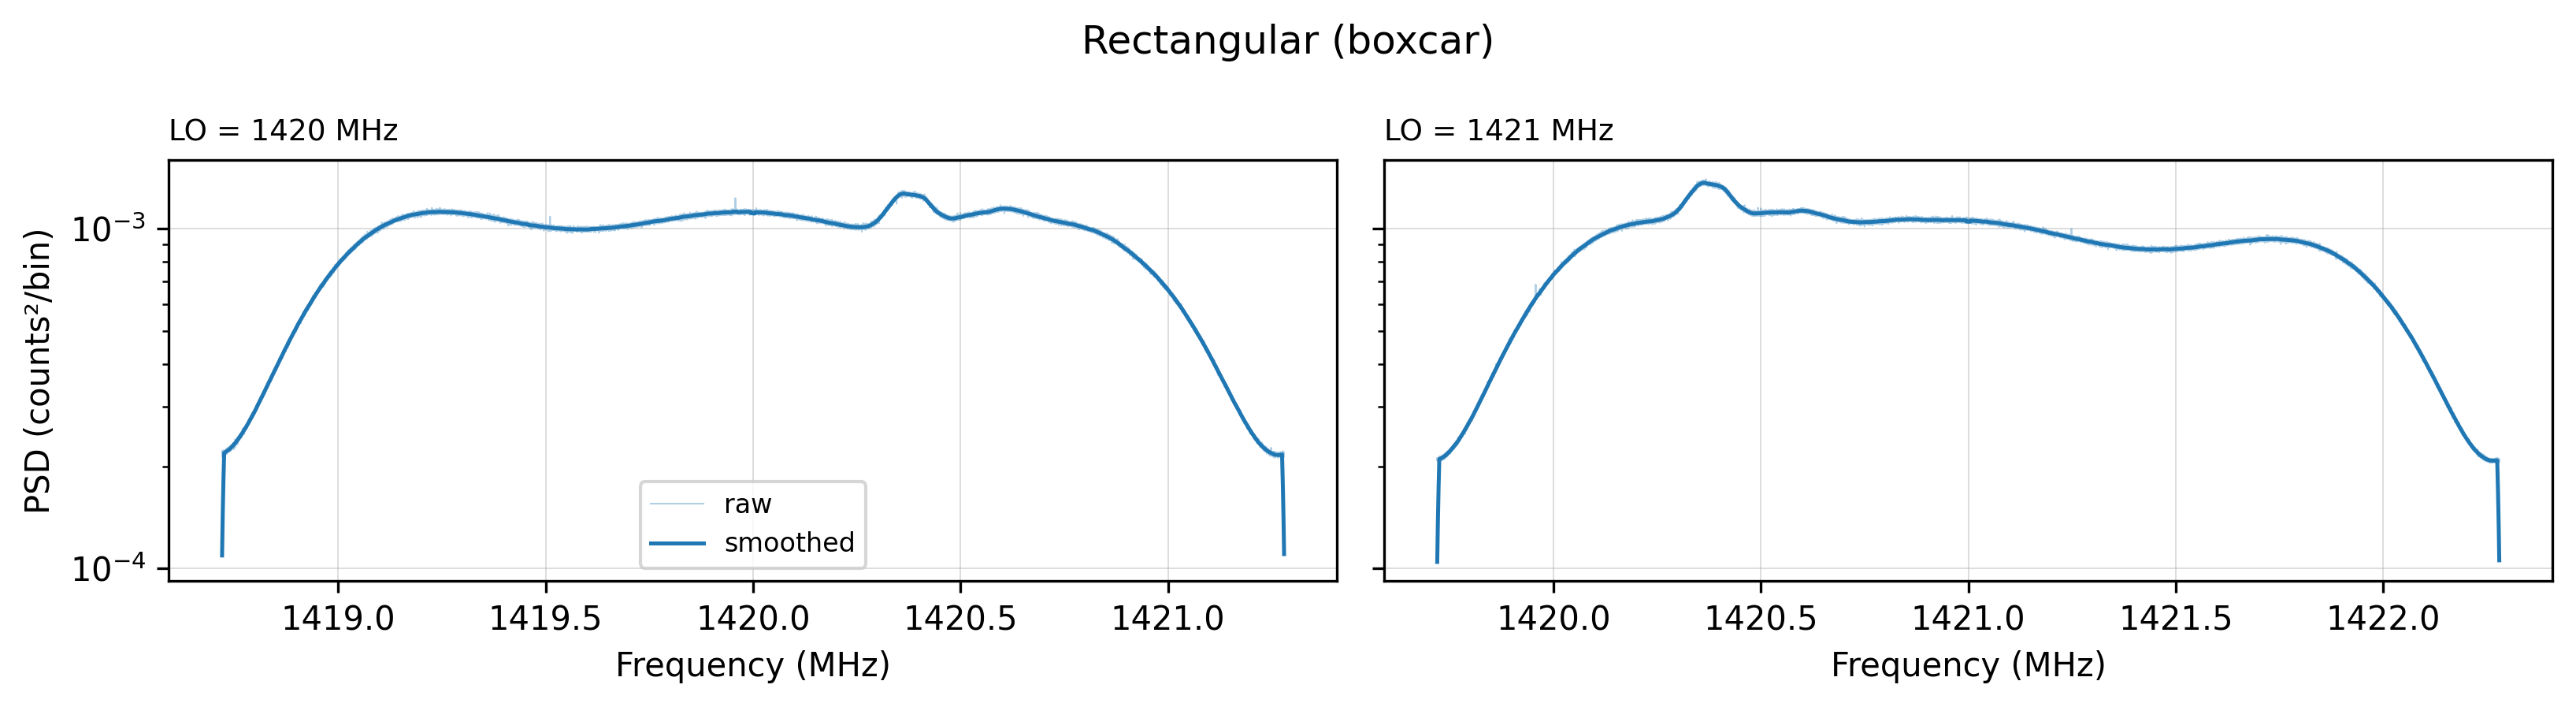

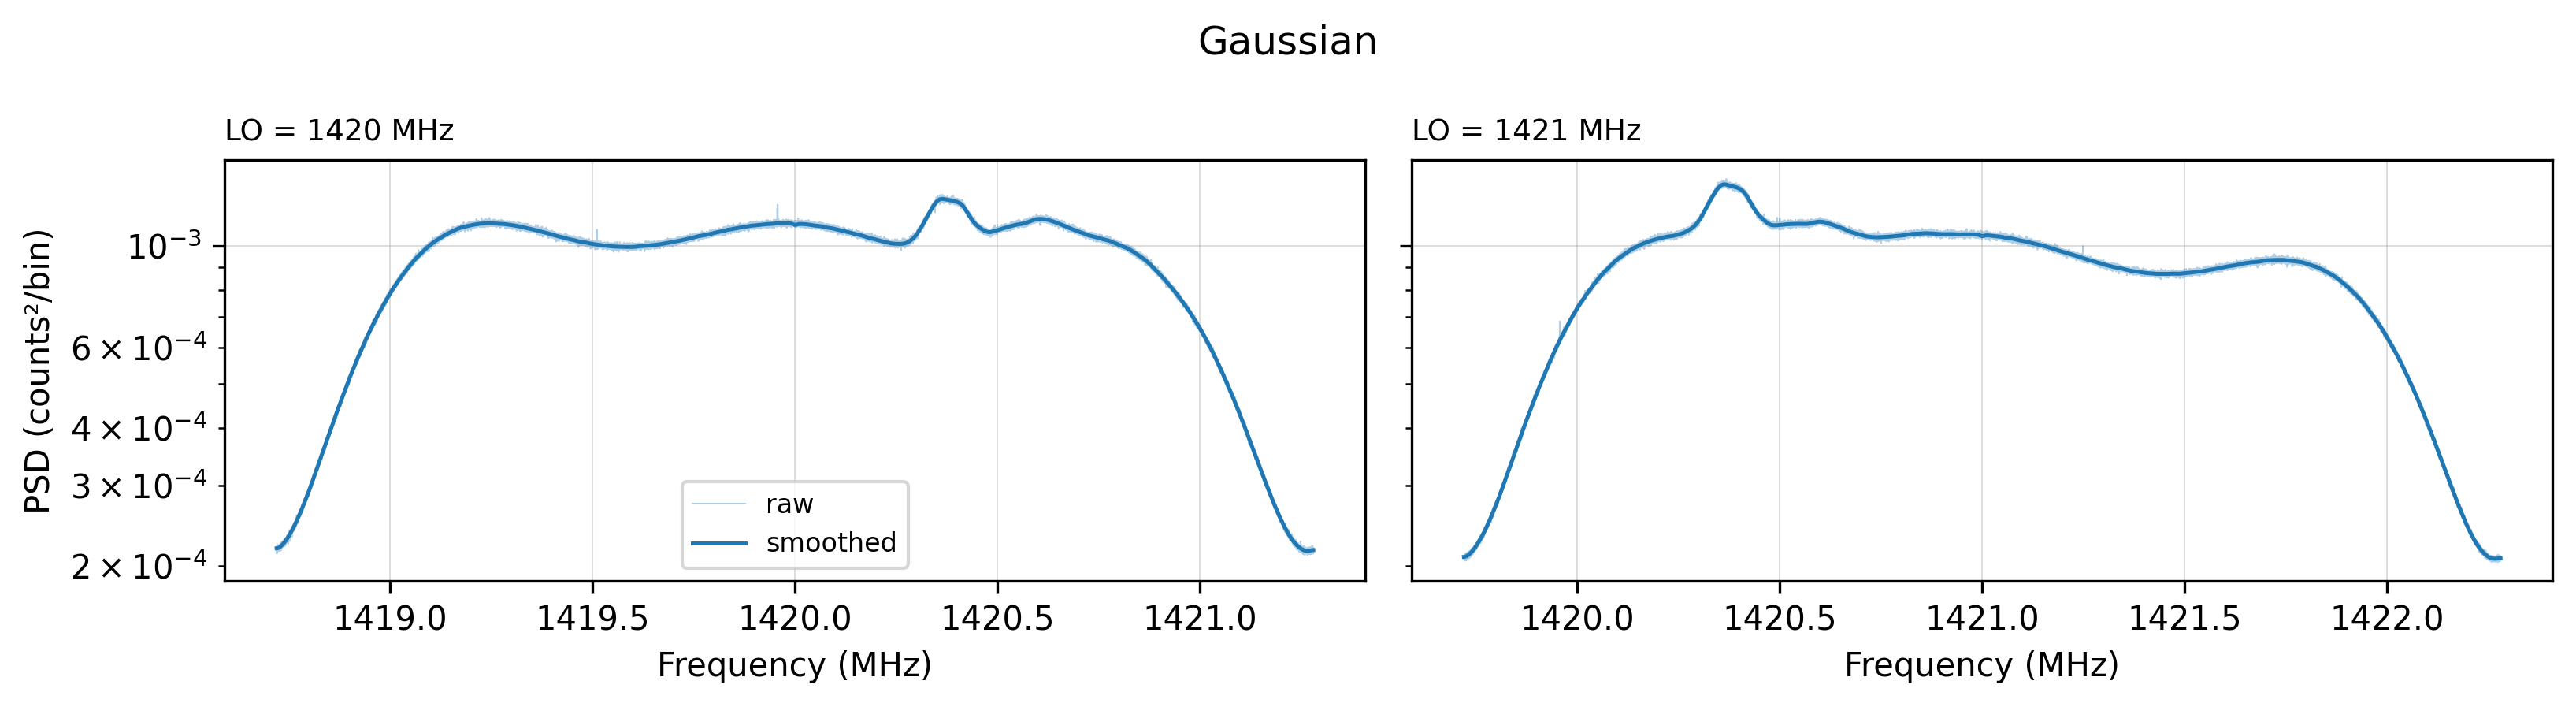

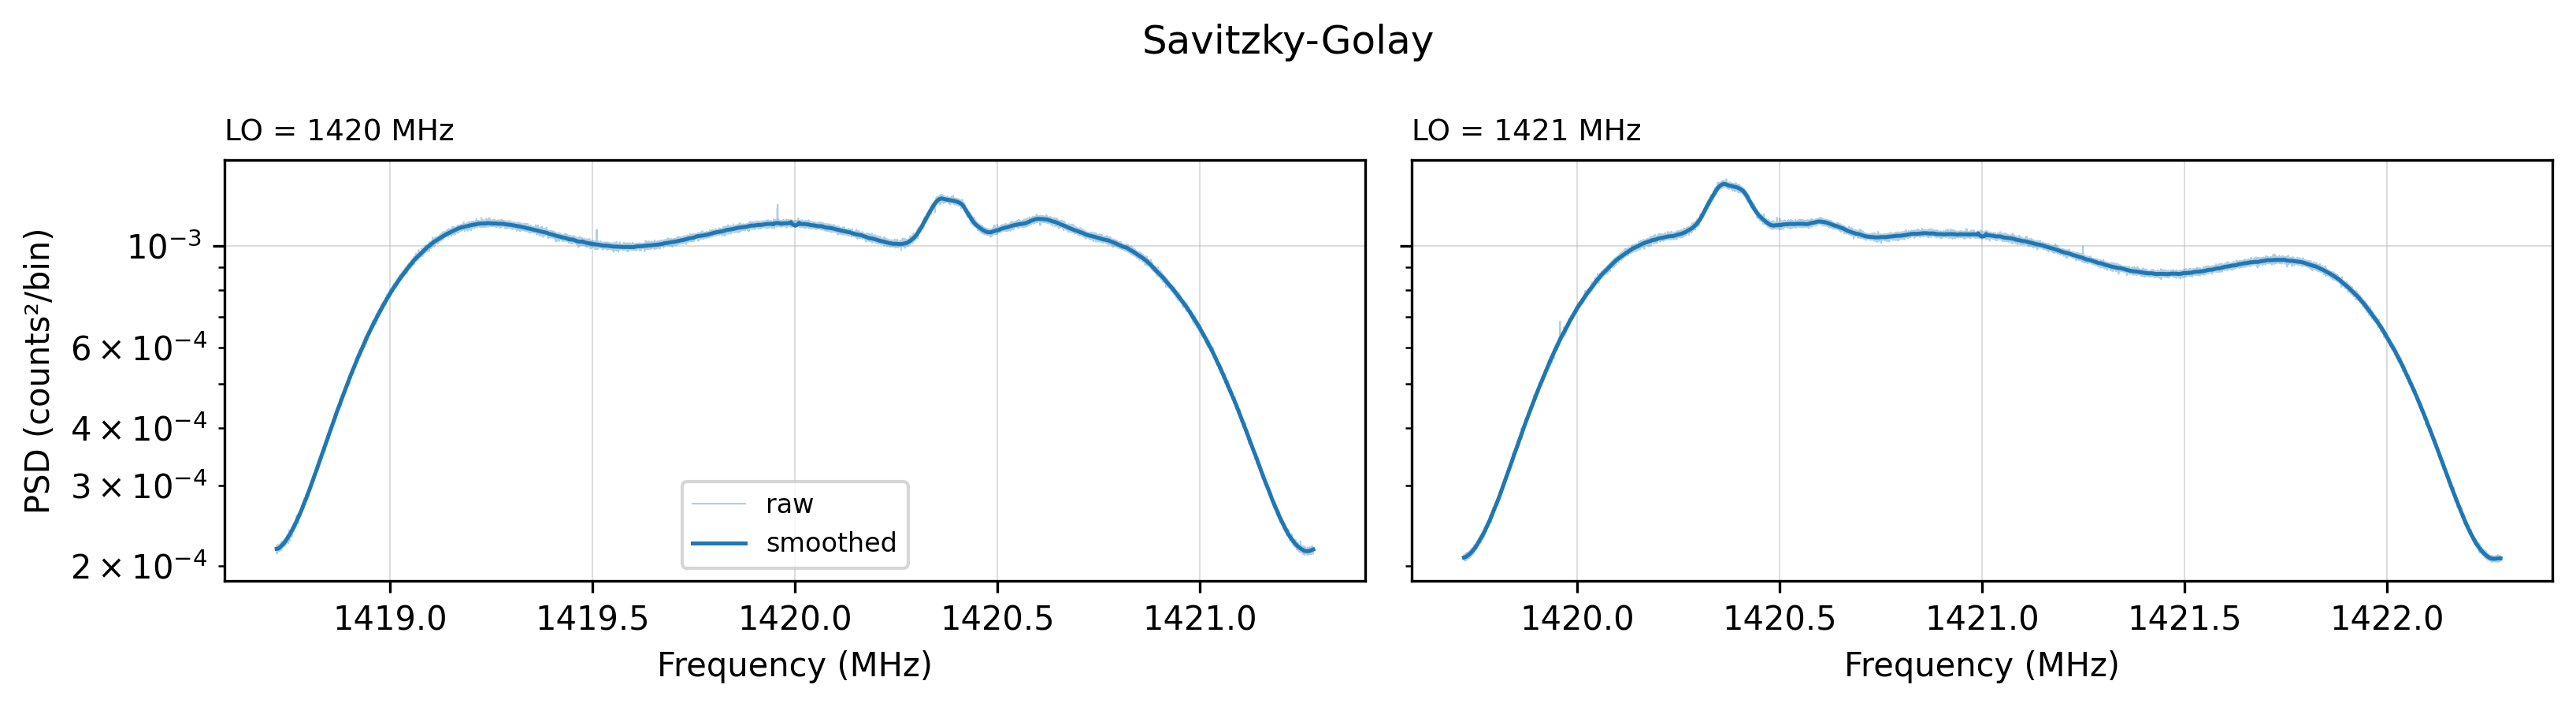

In [8]:
spec_1420 = next(s for s in long_spectra if abs(s.center_freq - 1420e6) < 0.5e6)
spec_1421 = next(s for s in long_spectra if abs(s.center_freq - 1421e6) < 0.5e6)

smoothing_methods = [
    ('Rectangular (boxcar)',  dict(method='boxcar',   M=128)),
    ('Gaussian',              dict(method='gaussian', sigma=64)),
    ('Savitzky-Golay',        dict(method='savgol',   window_length=257, polyorder=3)),
]

for title, kwargs in smoothing_methods:
    fig, axes = plt.subplots(1, 2, figsize=(11, 3), dpi=300, sharey=True)
    for ax, spec, label in zip(axes, [spec_1420, spec_1421], ['1420 MHz', '1421 MHz']):
        psd_raw = psd_without_dc(spec)
        psd_smooth = spec.smooth(**kwargs)

        ax.semilogy(spec.freqs_mhz, psd_raw,    color='C0', lw=0.5, alpha=0.35, label='raw')
        ax.semilogy(spec.freqs_mhz, psd_smooth, color='C0', lw=1.2,             label='smoothed')
        ax.set_title(f'LO = {label}', fontsize=9, loc='left')
        ax.set_xlabel('Frequency (MHz)')
        ax.grid(True, lw=0.4, alpha=0.5)

    axes[0].set_ylabel('PSD (counts²/bin)')
    axes[0].legend(fontsize=8)
    fig.suptitle(title)
    fig.tight_layout()
    plt.show()


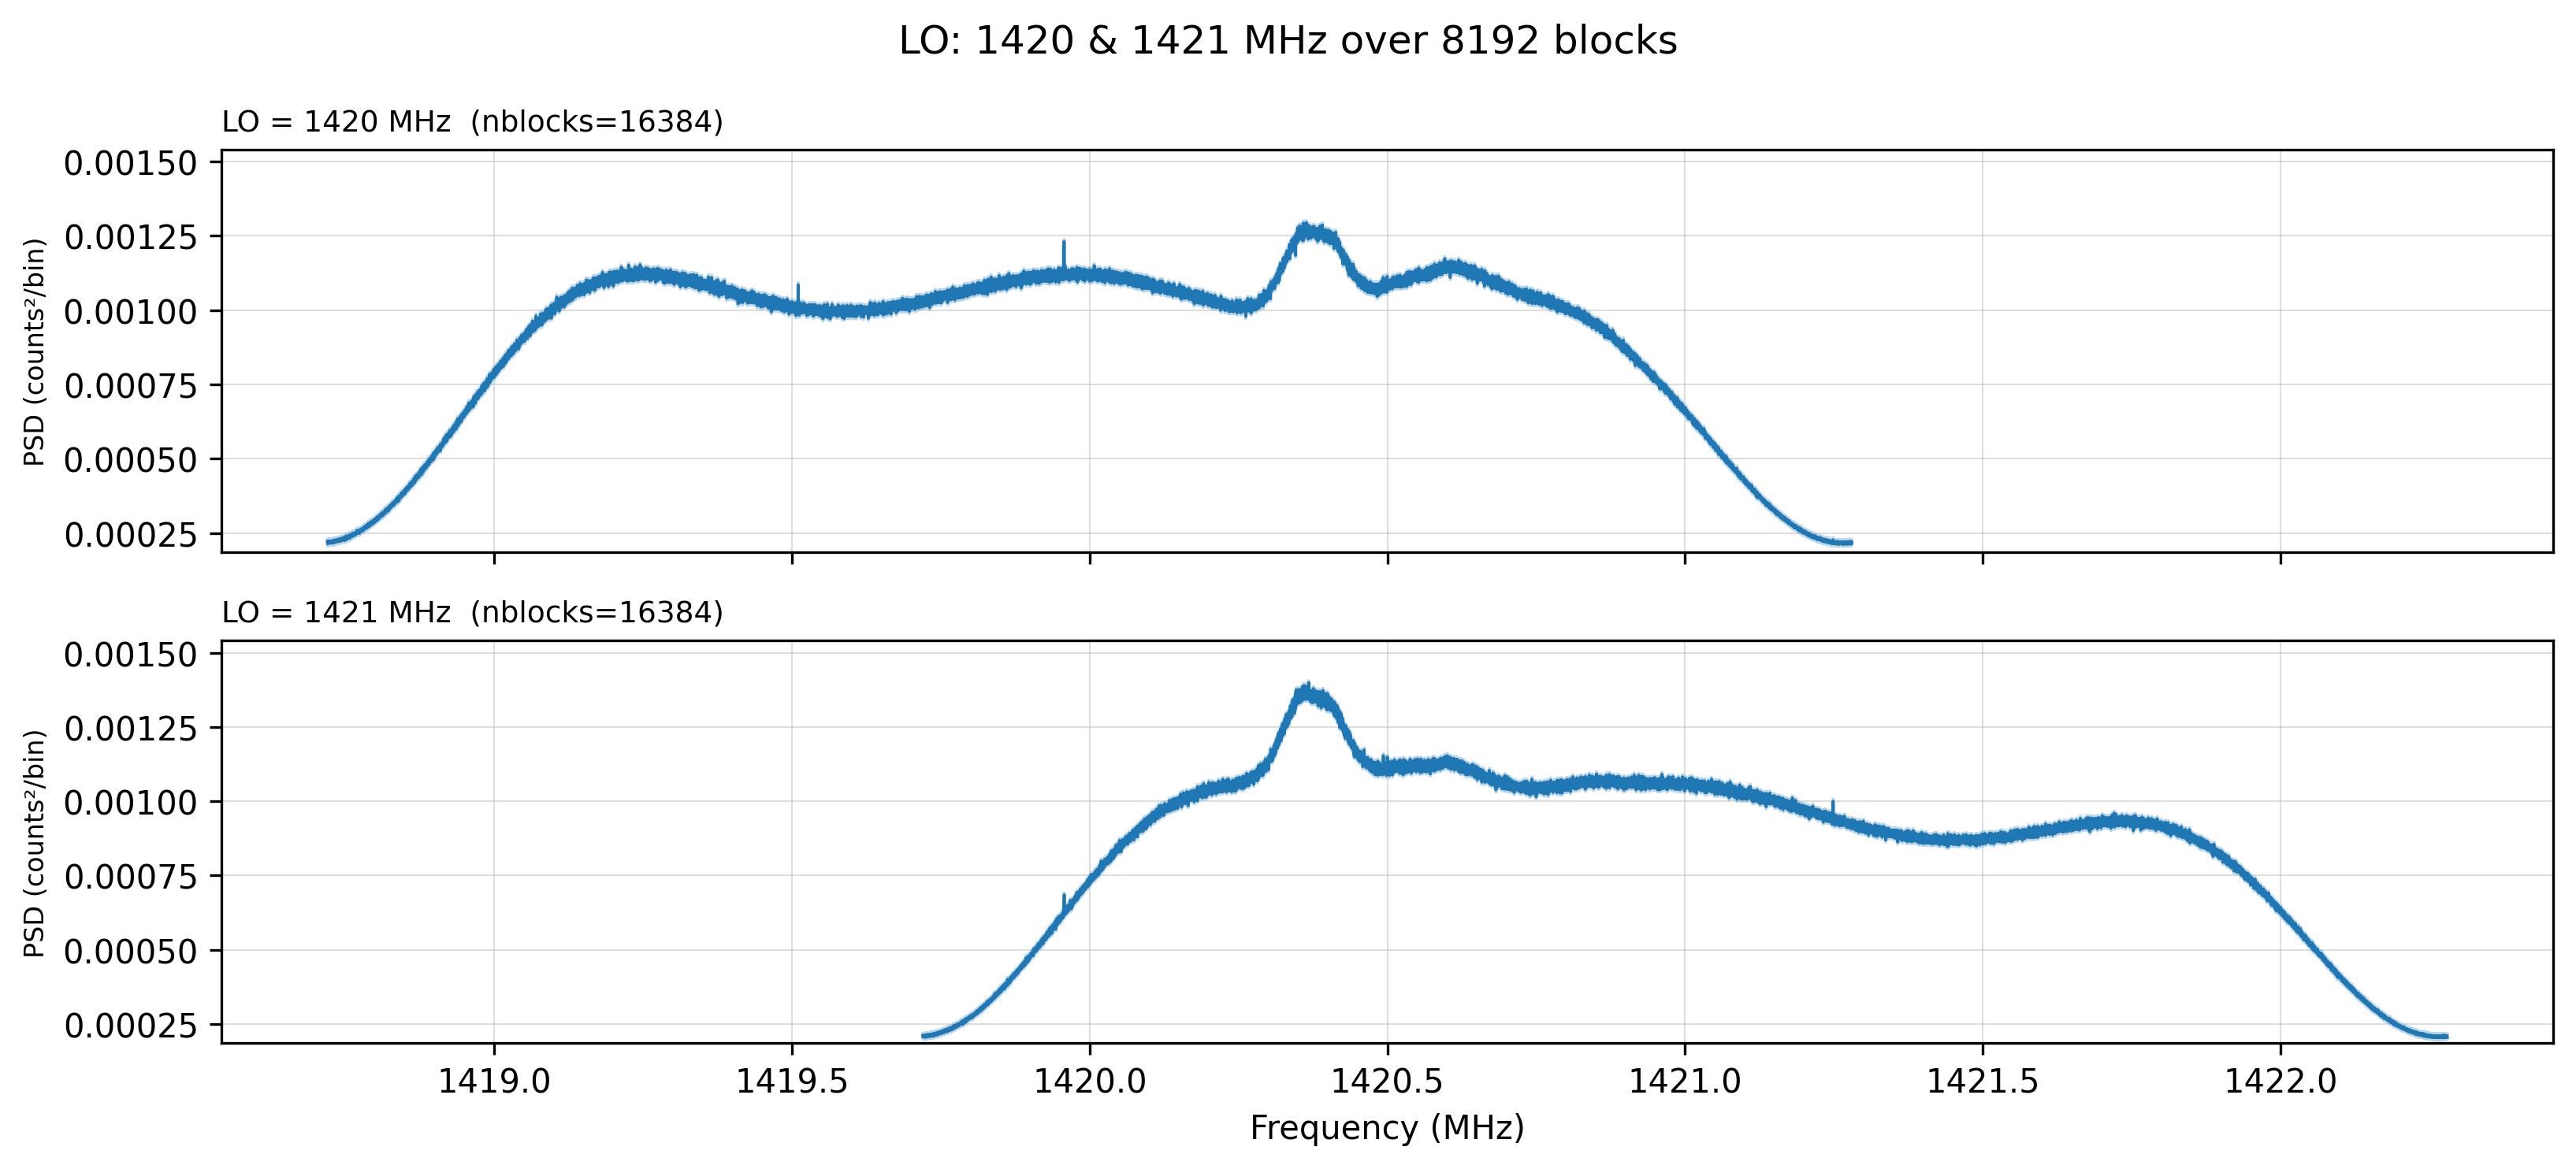

In [9]:
n = len(long_spectra)
fig, axes = plt.subplots(n, 1, figsize=(11, 2.5 * n), dpi=300, sharex=True, sharey=True)

all_psd = [psd_without_dc(spec) for spec in long_spectra]

finite_psd = np.concatenate([p[np.isfinite(p) & (p > 0)] for p in all_psd])
x_all = np.concatenate([spec.freqs_mhz for spec in long_spectra])
x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = finite_psd.min(), finite_psd.max()

x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (np.log10(y_max) - np.log10(y_min))

for ax, spec, psd in zip(axes, long_spectra, all_psd):
    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std, alpha=0.3, color='C0')
    ax.plot(spec.freqs_mhz, psd, lw=0.9, color='C0')
    ax.set_ylabel('PSD (counts²/bin)', fontsize=8)
    ax.set_title(f'LO = {spec.center_freq/1e6:.0f} MHz  (nblocks={spec.nblocks})', fontsize=9, loc='left')
    ax.grid(True, lw=0.4, alpha=0.5)

axes[0].set_xlim(x_min - x_pad, x_max + x_pad)
axes[0].set_ylim(10 ** (np.log10(y_min) - y_pad), 10 ** (np.log10(y_max) + y_pad))
axes[-1].set_xlabel('Frequency (MHz)')
fig.suptitle('LO: 1420 & 1421 MHz over 8192 blocks')
fig.tight_layout()
plt.show()

In [10]:
HUMAN_DIR = os.path.join(DATA_ROOT, 'human_combined')

human_spectra = load_or_process(HUMAN_DIR)
human_spectra.sort(key=lambda s: s.center_freq)

for spec in human_spectra:
    print(f'  LO={spec.center_freq/1e6:.0f} MHz  nblocks={spec.nblocks}  total_power={spec.total_power:.4f}')


Loading pre-processed SpectrumLite from ../../data/lab02/human_combined_lite
  LO=1420 MHz  nblocks=16384  total_power=110.4312
  LO=1421 MHz  nblocks=16384  total_power=107.4256


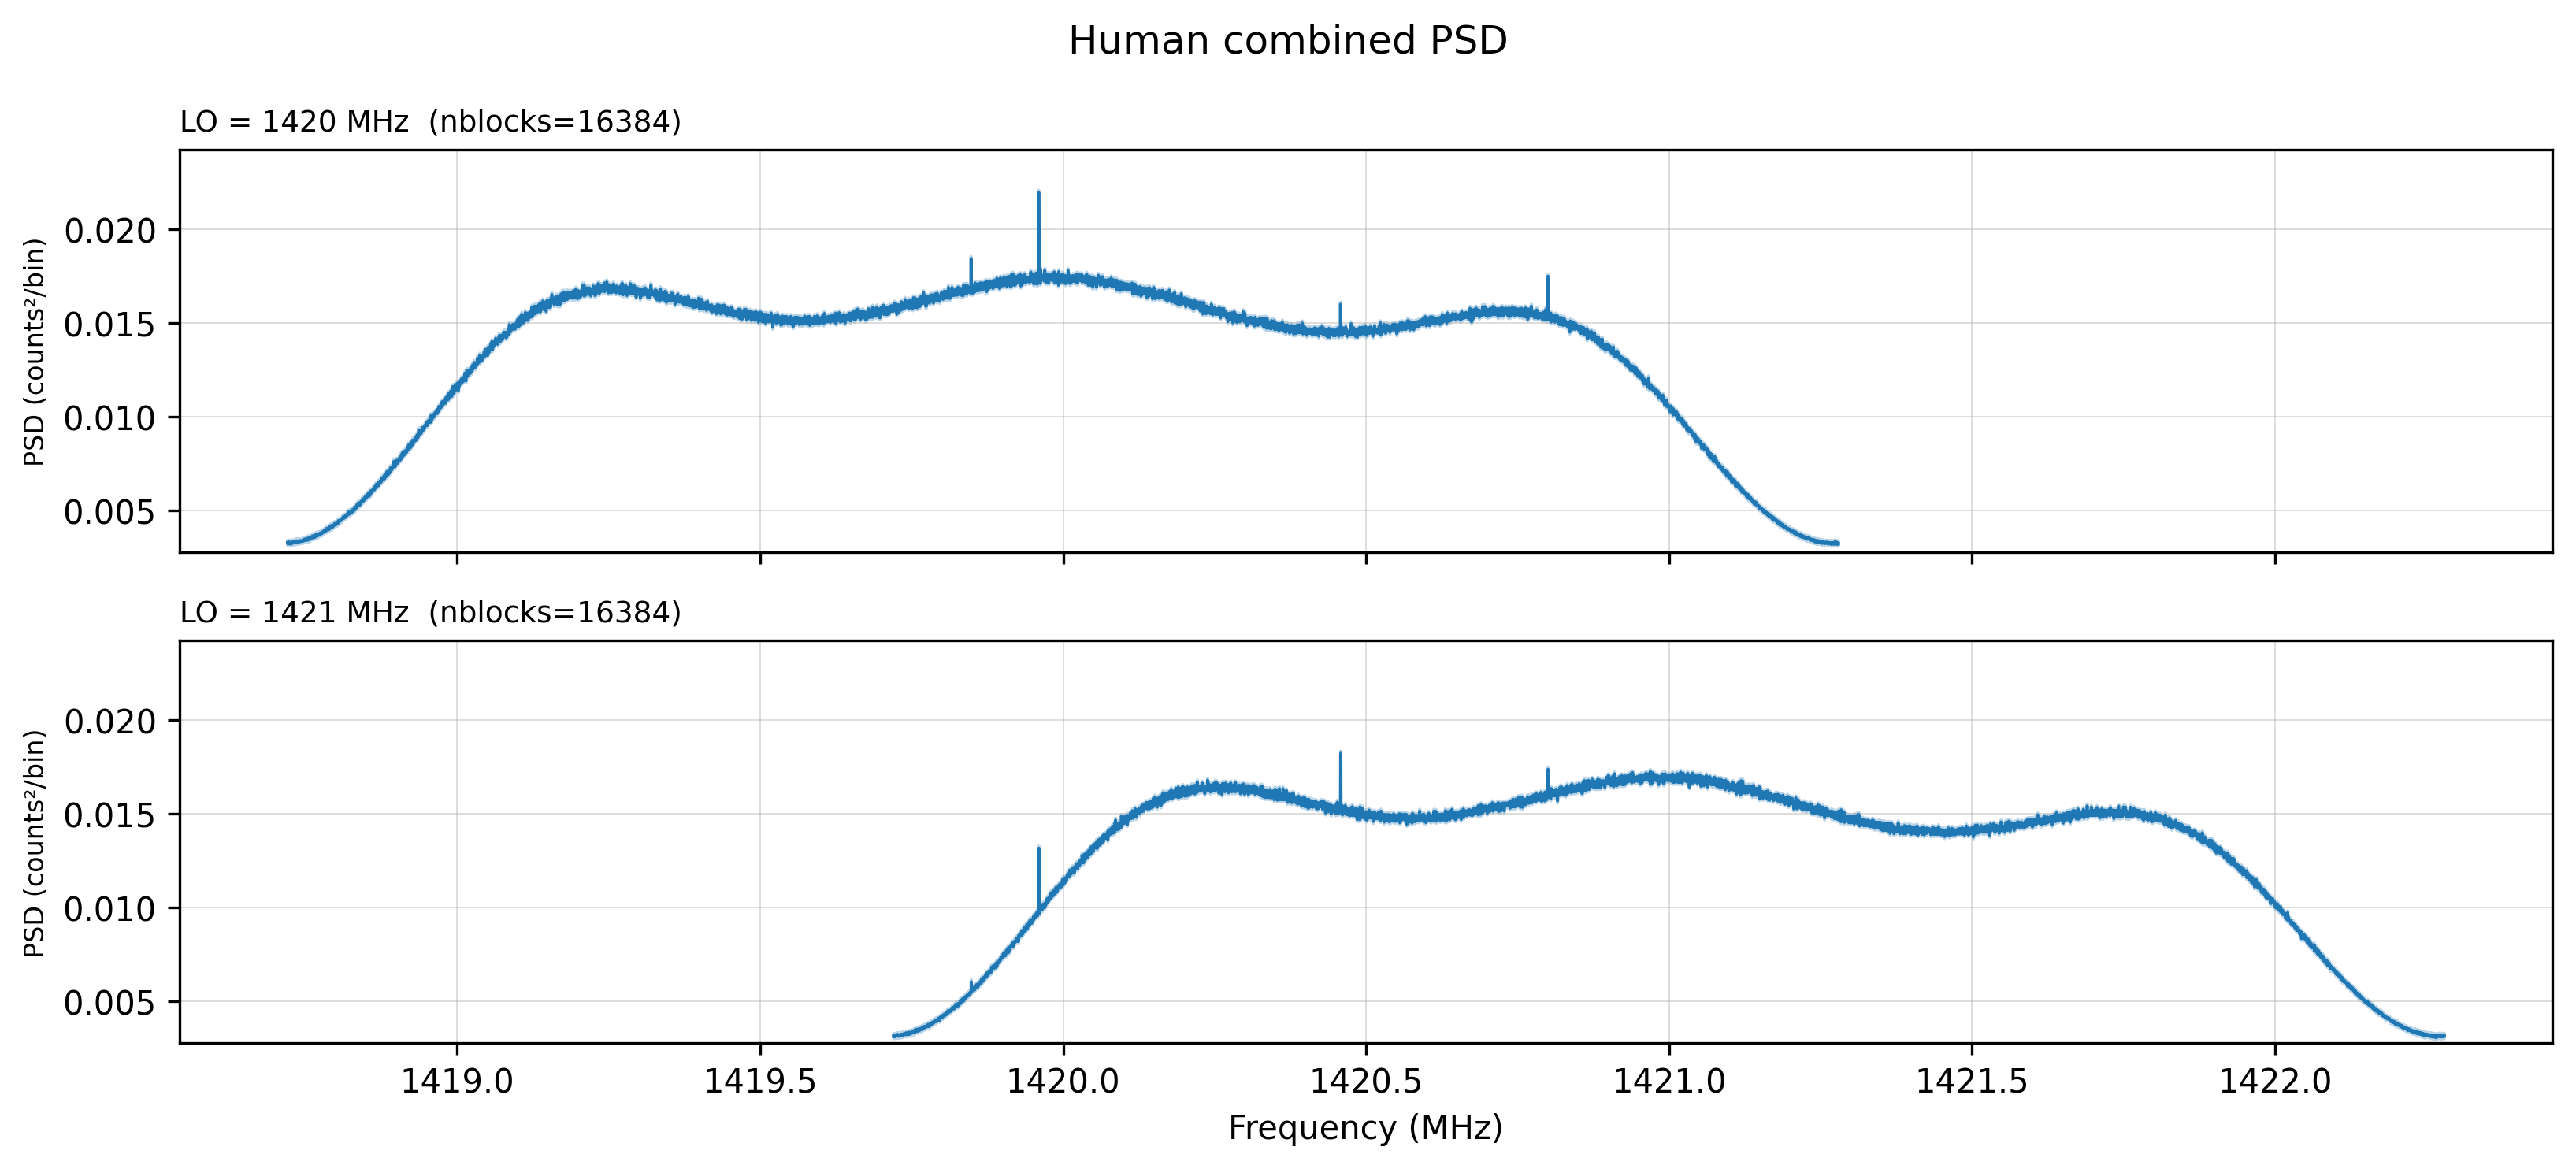

In [11]:
n = len(human_spectra)
if n == 0:
    raise ValueError('No spectra found in HUMAN_DIR. Generate human_combined .npz first.')

fig, axes = plt.subplots(n, 1, figsize=(11, 2.5 * n), dpi=300, sharex=True, sharey=True)
if n == 1:
    axes = [axes]

all_psd = [psd_without_dc(spec) for spec in human_spectra]

finite_psd = np.concatenate([p[np.isfinite(p) & (p > 0)] for p in all_psd])
x_all = np.concatenate([spec.freqs_mhz for spec in human_spectra])
x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = finite_psd.min(), finite_psd.max()

x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (np.log10(y_max) - np.log10(y_min))

for ax, spec, psd in zip(axes, human_spectra, all_psd):
    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std, alpha=0.3, color='C0')
    ax.plot(spec.freqs_mhz, psd, lw=0.9, color='C0')
    ax.set_ylabel('PSD (counts²/bin)', fontsize=8)
    ax.set_title(f'LO = {spec.center_freq/1e6:.0f} MHz  (nblocks={spec.nblocks})', fontsize=9, loc='left')
    ax.grid(True, lw=0.4, alpha=0.5)

axes[0].set_xlim(x_min - x_pad, x_max + x_pad)
axes[0].set_ylim(10 ** (np.log10(y_min) - y_pad), 10 ** (np.log10(y_max) + y_pad))
axes[-1].set_xlabel('Frequency (MHz)')
fig.suptitle('Human combined PSD')
fig.tight_layout()
plt.show()


In [12]:
LOW_HI_DIR = os.path.join(DATA_ROOT, 'low-hi_combined')

low_hi_spectra = load_or_process(LOW_HI_DIR)
low_hi_spectra.sort(key=lambda s: s.center_freq)

for spec in low_hi_spectra:
    print(f'  LO={spec.center_freq/1e6:.0f} MHz  nblocks={spec.nblocks}  total_power={spec.total_power:.4f}')


Loading pre-processed SpectrumLite from ../../data/lab02/low-hi_combined_lite
  LO=1420 MHz  nblocks=16384  total_power=30.3330
  LO=1421 MHz  nblocks=16384  total_power=29.4739


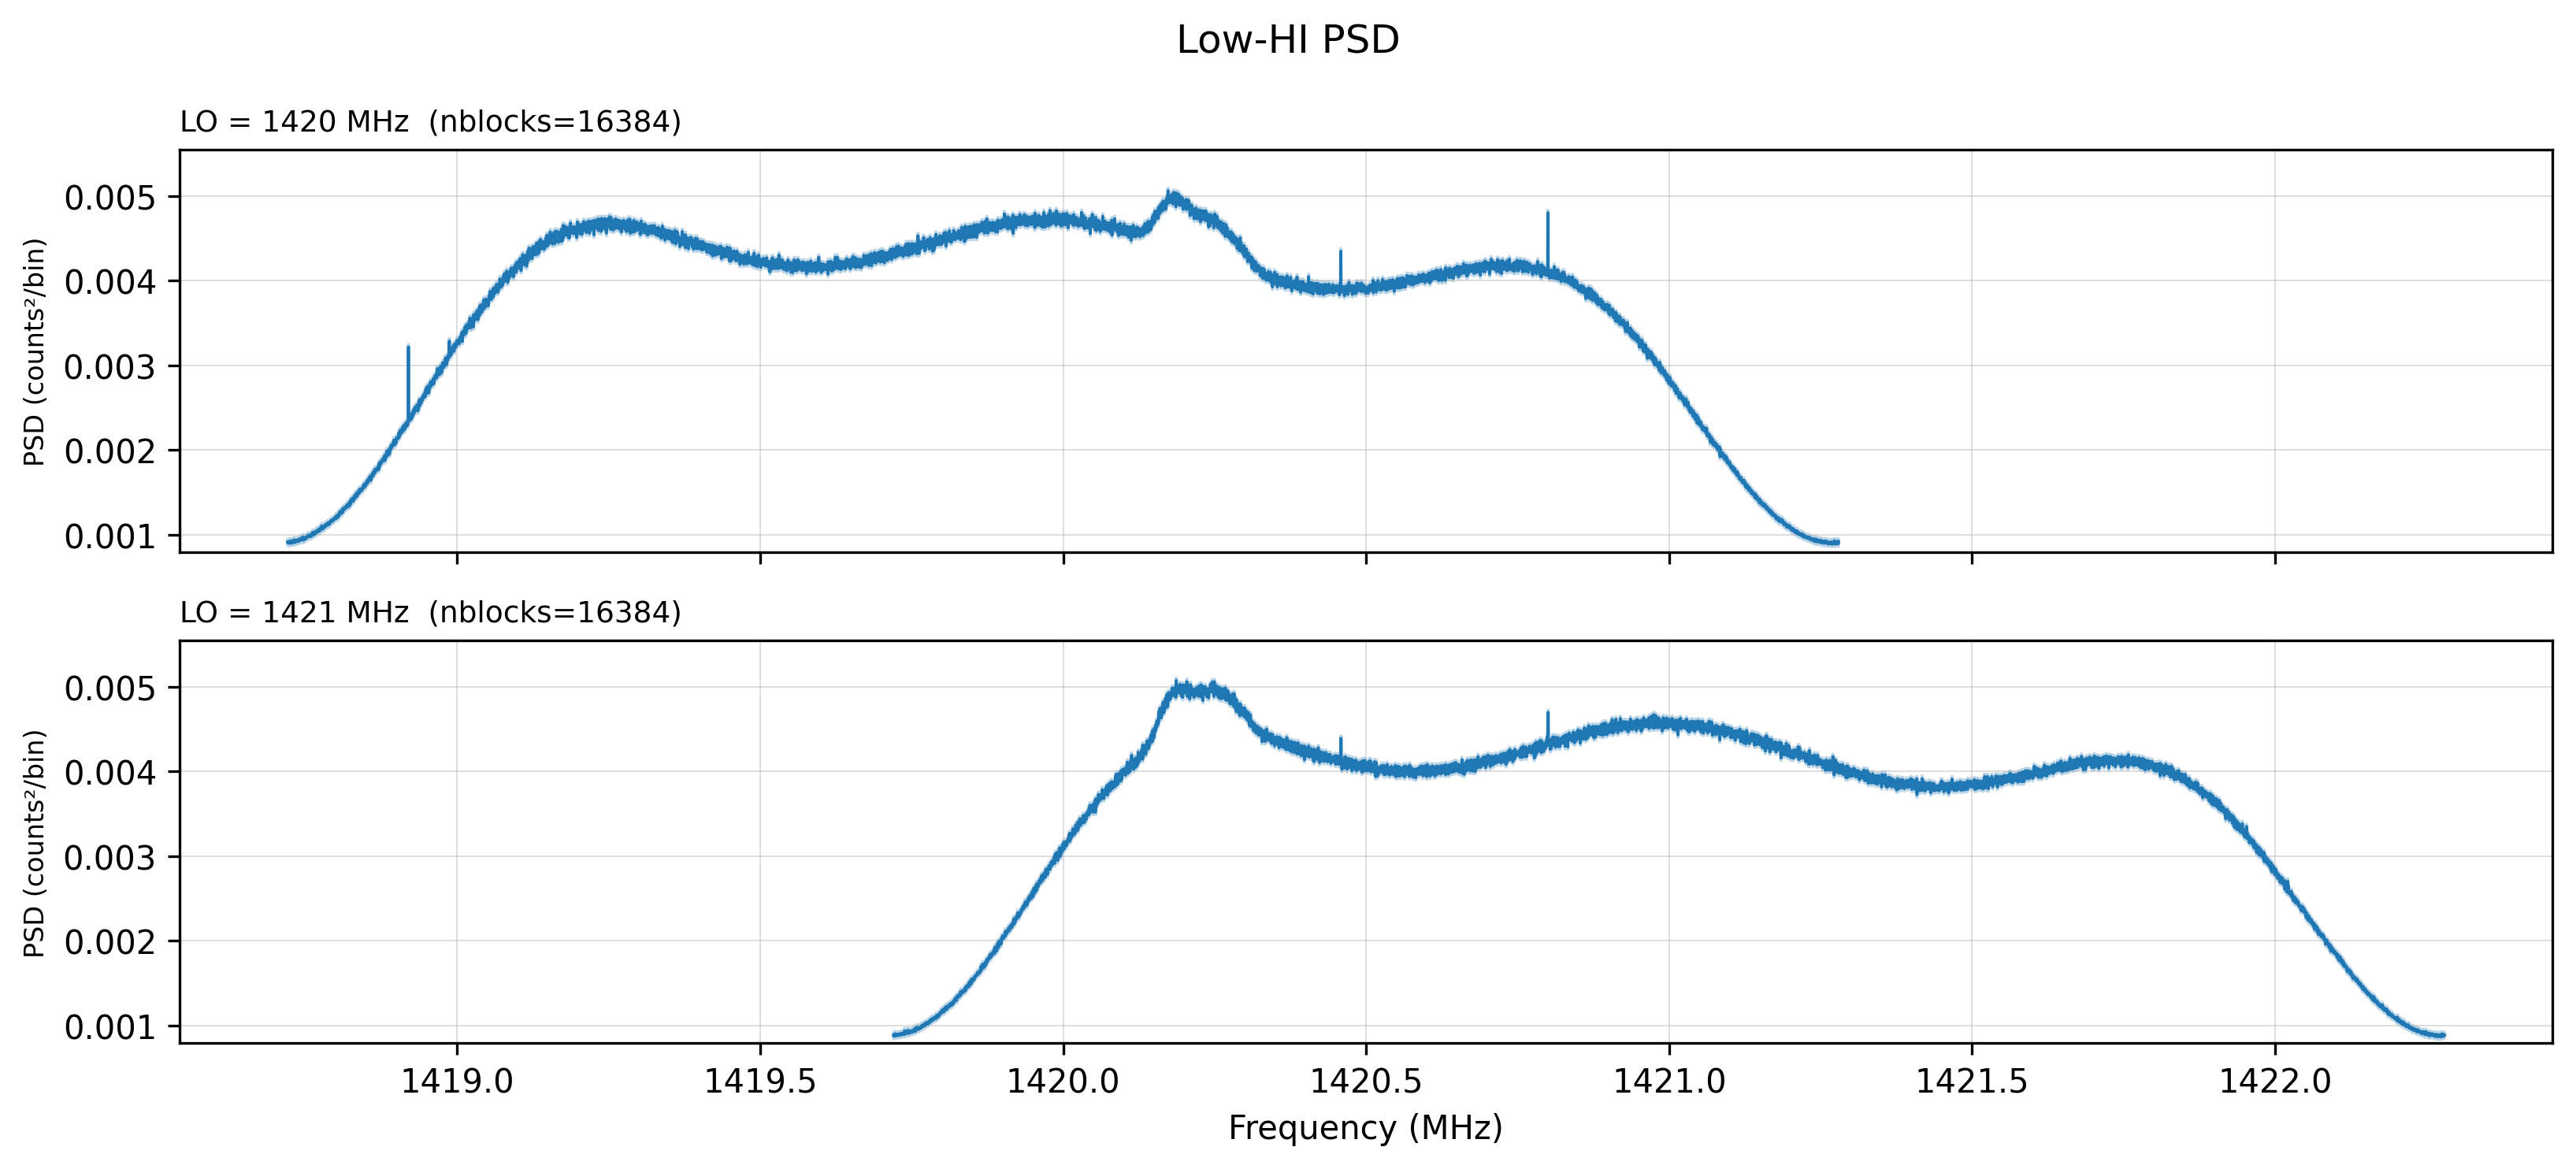

In [13]:
n = len(low_hi_spectra)
if n == 0:
    raise ValueError('No spectra found in LOW_HI_DIR. Generate low-hi_combined .npz first.')

fig, axes = plt.subplots(n, 1, figsize=(11, 2.5 * n), dpi=300, sharex=True, sharey=True)
if n == 1:
    axes = [axes]

all_psd = [psd_without_dc(spec) for spec in low_hi_spectra]

finite_psd = np.concatenate([p[np.isfinite(p) & (p > 0)] for p in all_psd])
x_all = np.concatenate([spec.freqs_mhz for spec in low_hi_spectra])
x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = finite_psd.min(), finite_psd.max()

x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (np.log10(y_max) - np.log10(y_min))

for ax, spec, psd in zip(axes, low_hi_spectra, all_psd):
    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std, alpha=0.3, color='C0')
    ax.plot(spec.freqs_mhz, psd, lw=0.9, color='C0')
    ax.set_ylabel('PSD (counts²/bin)', fontsize=8)
    ax.set_title(f'LO = {spec.center_freq/1e6:.0f} MHz  (nblocks={spec.nblocks})', fontsize=9, loc='left')
    ax.grid(True, lw=0.4, alpha=0.5)

axes[0].set_xlim(x_min - x_pad, x_max + x_pad)
axes[0].set_ylim(10 ** (np.log10(y_min) - y_pad), 10 ** (np.log10(y_max) + y_pad))
axes[-1].set_xlabel('Frequency (MHz)')
fig.suptitle('Low-HI PSD')
fig.tight_layout()
plt.show()


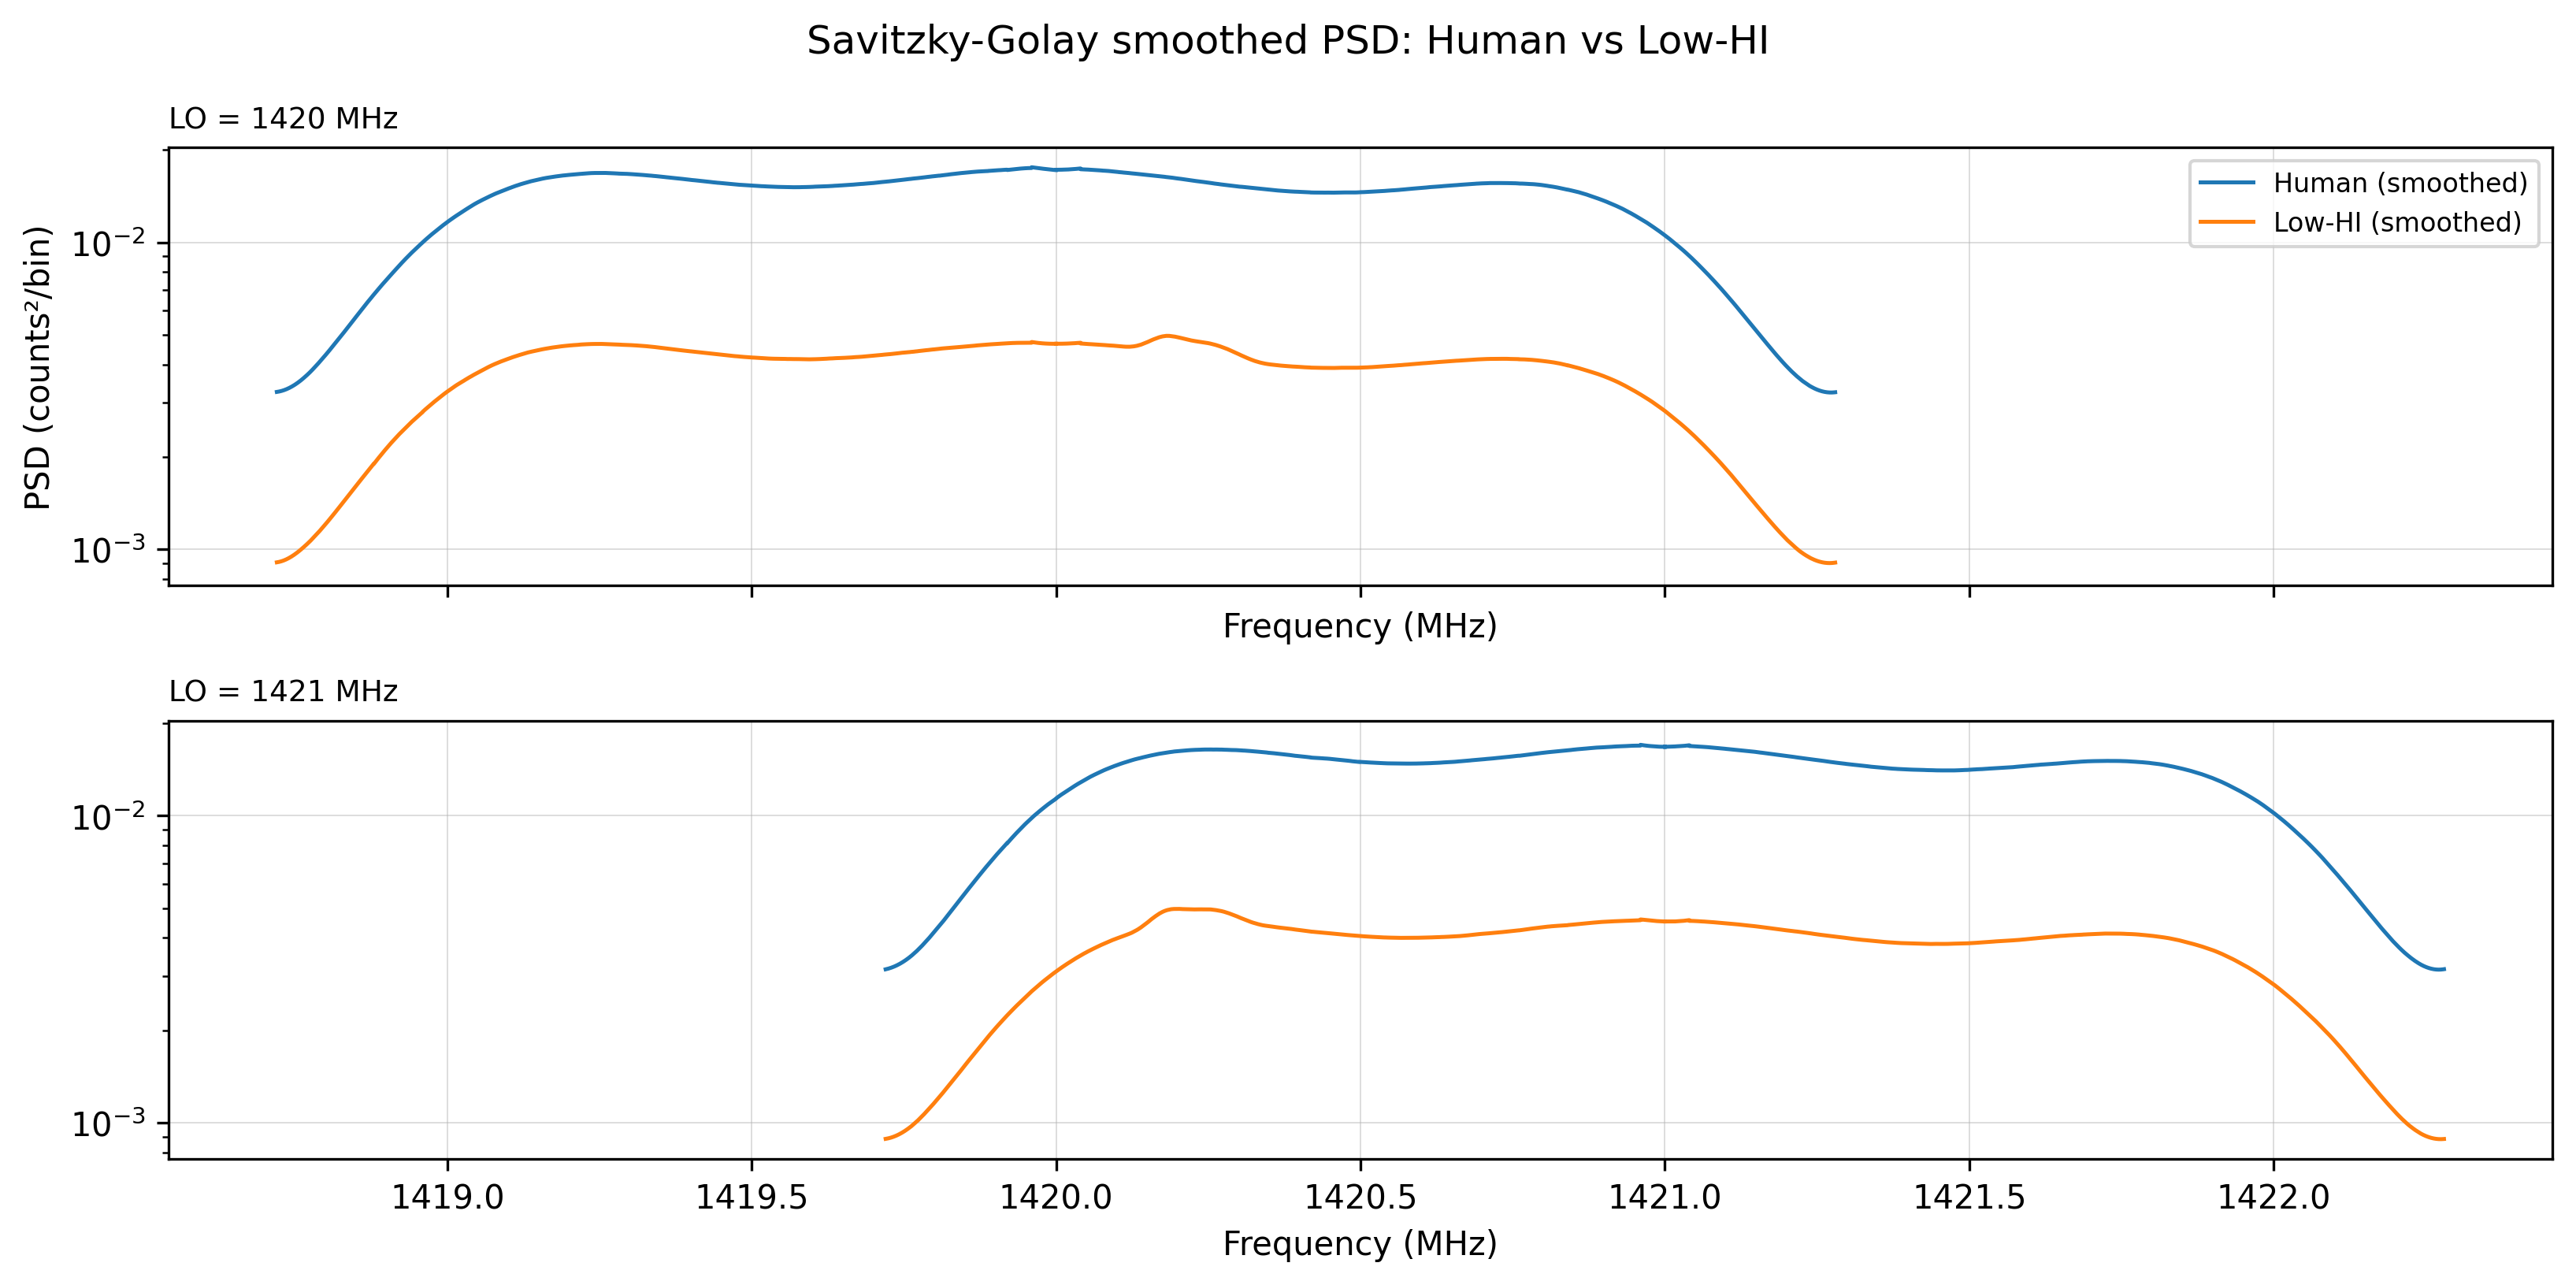

In [14]:
target_los = [1420e6, 1421e6]
tol_hz = 0.5e6
savgol_kwargs = dict(method='savgol', window_length=257, polyorder=3)

def pick_by_lo(spectra, lo_hz, tol=tol_hz):
    matches = [s for s in spectra if abs(s.center_freq - lo_hz) < tol]
    if not matches:
        raise ValueError(f'No spectrum found near LO={lo_hz/1e6:.0f} MHz')
    return matches[0]

def smooth_without_dc(spec, **kwargs):
    vals = np.array(spec.smooth(**kwargs), dtype=float, copy=True)
    i0 = spec.bin_at(spec.center_freq)
    vals[max(0, i0):min(vals.size, i0 + 1)] = np.nan
    return vals

human_by_lo = {lo: pick_by_lo(human_spectra, lo) for lo in target_los}
low_hi_by_lo = {lo: pick_by_lo(low_hi_spectra, lo) for lo in target_los}

fig, axes = plt.subplots(2, 1, figsize=(11, 5.5), dpi=300, sharex=True, sharey=True)

all_psd = []
x_all = []

for ax, lo in zip(axes, target_los):
    human_spec = human_by_lo[lo]
    low_hi_spec = low_hi_by_lo[lo]

    human_smooth = smooth_without_dc(human_spec, **savgol_kwargs)
    low_hi_smooth = smooth_without_dc(low_hi_spec, **savgol_kwargs)

    all_psd.extend([human_smooth, low_hi_smooth])
    x_all.extend([human_spec.freqs_mhz, low_hi_spec.freqs_mhz])

    ax.semilogy(human_spec.freqs_mhz, human_smooth, color='C0', lw=1.2, label='Human (smoothed)')
    ax.semilogy(low_hi_spec.freqs_mhz, low_hi_smooth, color='C1', lw=1.2, label='Low-HI (smoothed)')
    ax.set_title(f'LO = {lo/1e6:.0f} MHz', fontsize=9, loc='left')
    ax.set_xlabel('Frequency (MHz)')
    ax.grid(True, lw=0.4, alpha=0.5)

finite_psd = np.concatenate([p[np.isfinite(p) & (p > 0)] for p in all_psd])
x_concat = np.concatenate(x_all)
x_min, x_max = x_concat.min(), x_concat.max()
y_min, y_max = finite_psd.min(), finite_psd.max()

x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (np.log10(y_max) - np.log10(y_min))

axes[0].set_xlim(x_min - x_pad, x_max + x_pad)
axes[0].set_ylim(10 ** (np.log10(y_min) - y_pad), 10 ** (np.log10(y_max) + y_pad))
axes[0].set_ylabel('PSD (counts²/bin)')
axes[0].legend(fontsize=8)
fig.suptitle('Savitzky-Golay smoothed PSD: Human vs Low-HI')
fig.tight_layout()
plt.show()


## Analysis

Compute Y-factor and $T_{rx}$ directly from `human_combined` (hot) and `low-hi_combined` (cold), including propagated error bars.

- Power error bars are propagated from `SpectrumLite.std` into total integrated power.
- `T_{rx}` is reported with two uncertainties:
  - measurement-only (from power/Y uncertainty)
  - total (includes assumed $T_{hot}$ and $T_{cold}$ uncertainties)

Edit the temperature assumptions in the next cell if needed.


Y-factor and T_rx summary
--------------------------------------------------------------------------------------------------------------------------------
 LO    P_hot ± sigma      P_cold ± sigma      Y ± sigma (dB)          T_rx ± sigma_meas ± sigma_total [K]
--------------------------------------------------------------------------------------------------------------------------------
 1420  110.431196 ± 0.009559  30.332953 ± 0.002618  3.640635 ± 0.000445 (5.6118 ± 0.0005 dB)  76.035 ± 0.018 ± 13.792
 1421  107.425588 ± 0.009292  29.473895 ± 0.002544  3.644771 ± 0.000445 (5.6167 ± 0.0005 dB)  100.675 ± 0.019 ± 4.152


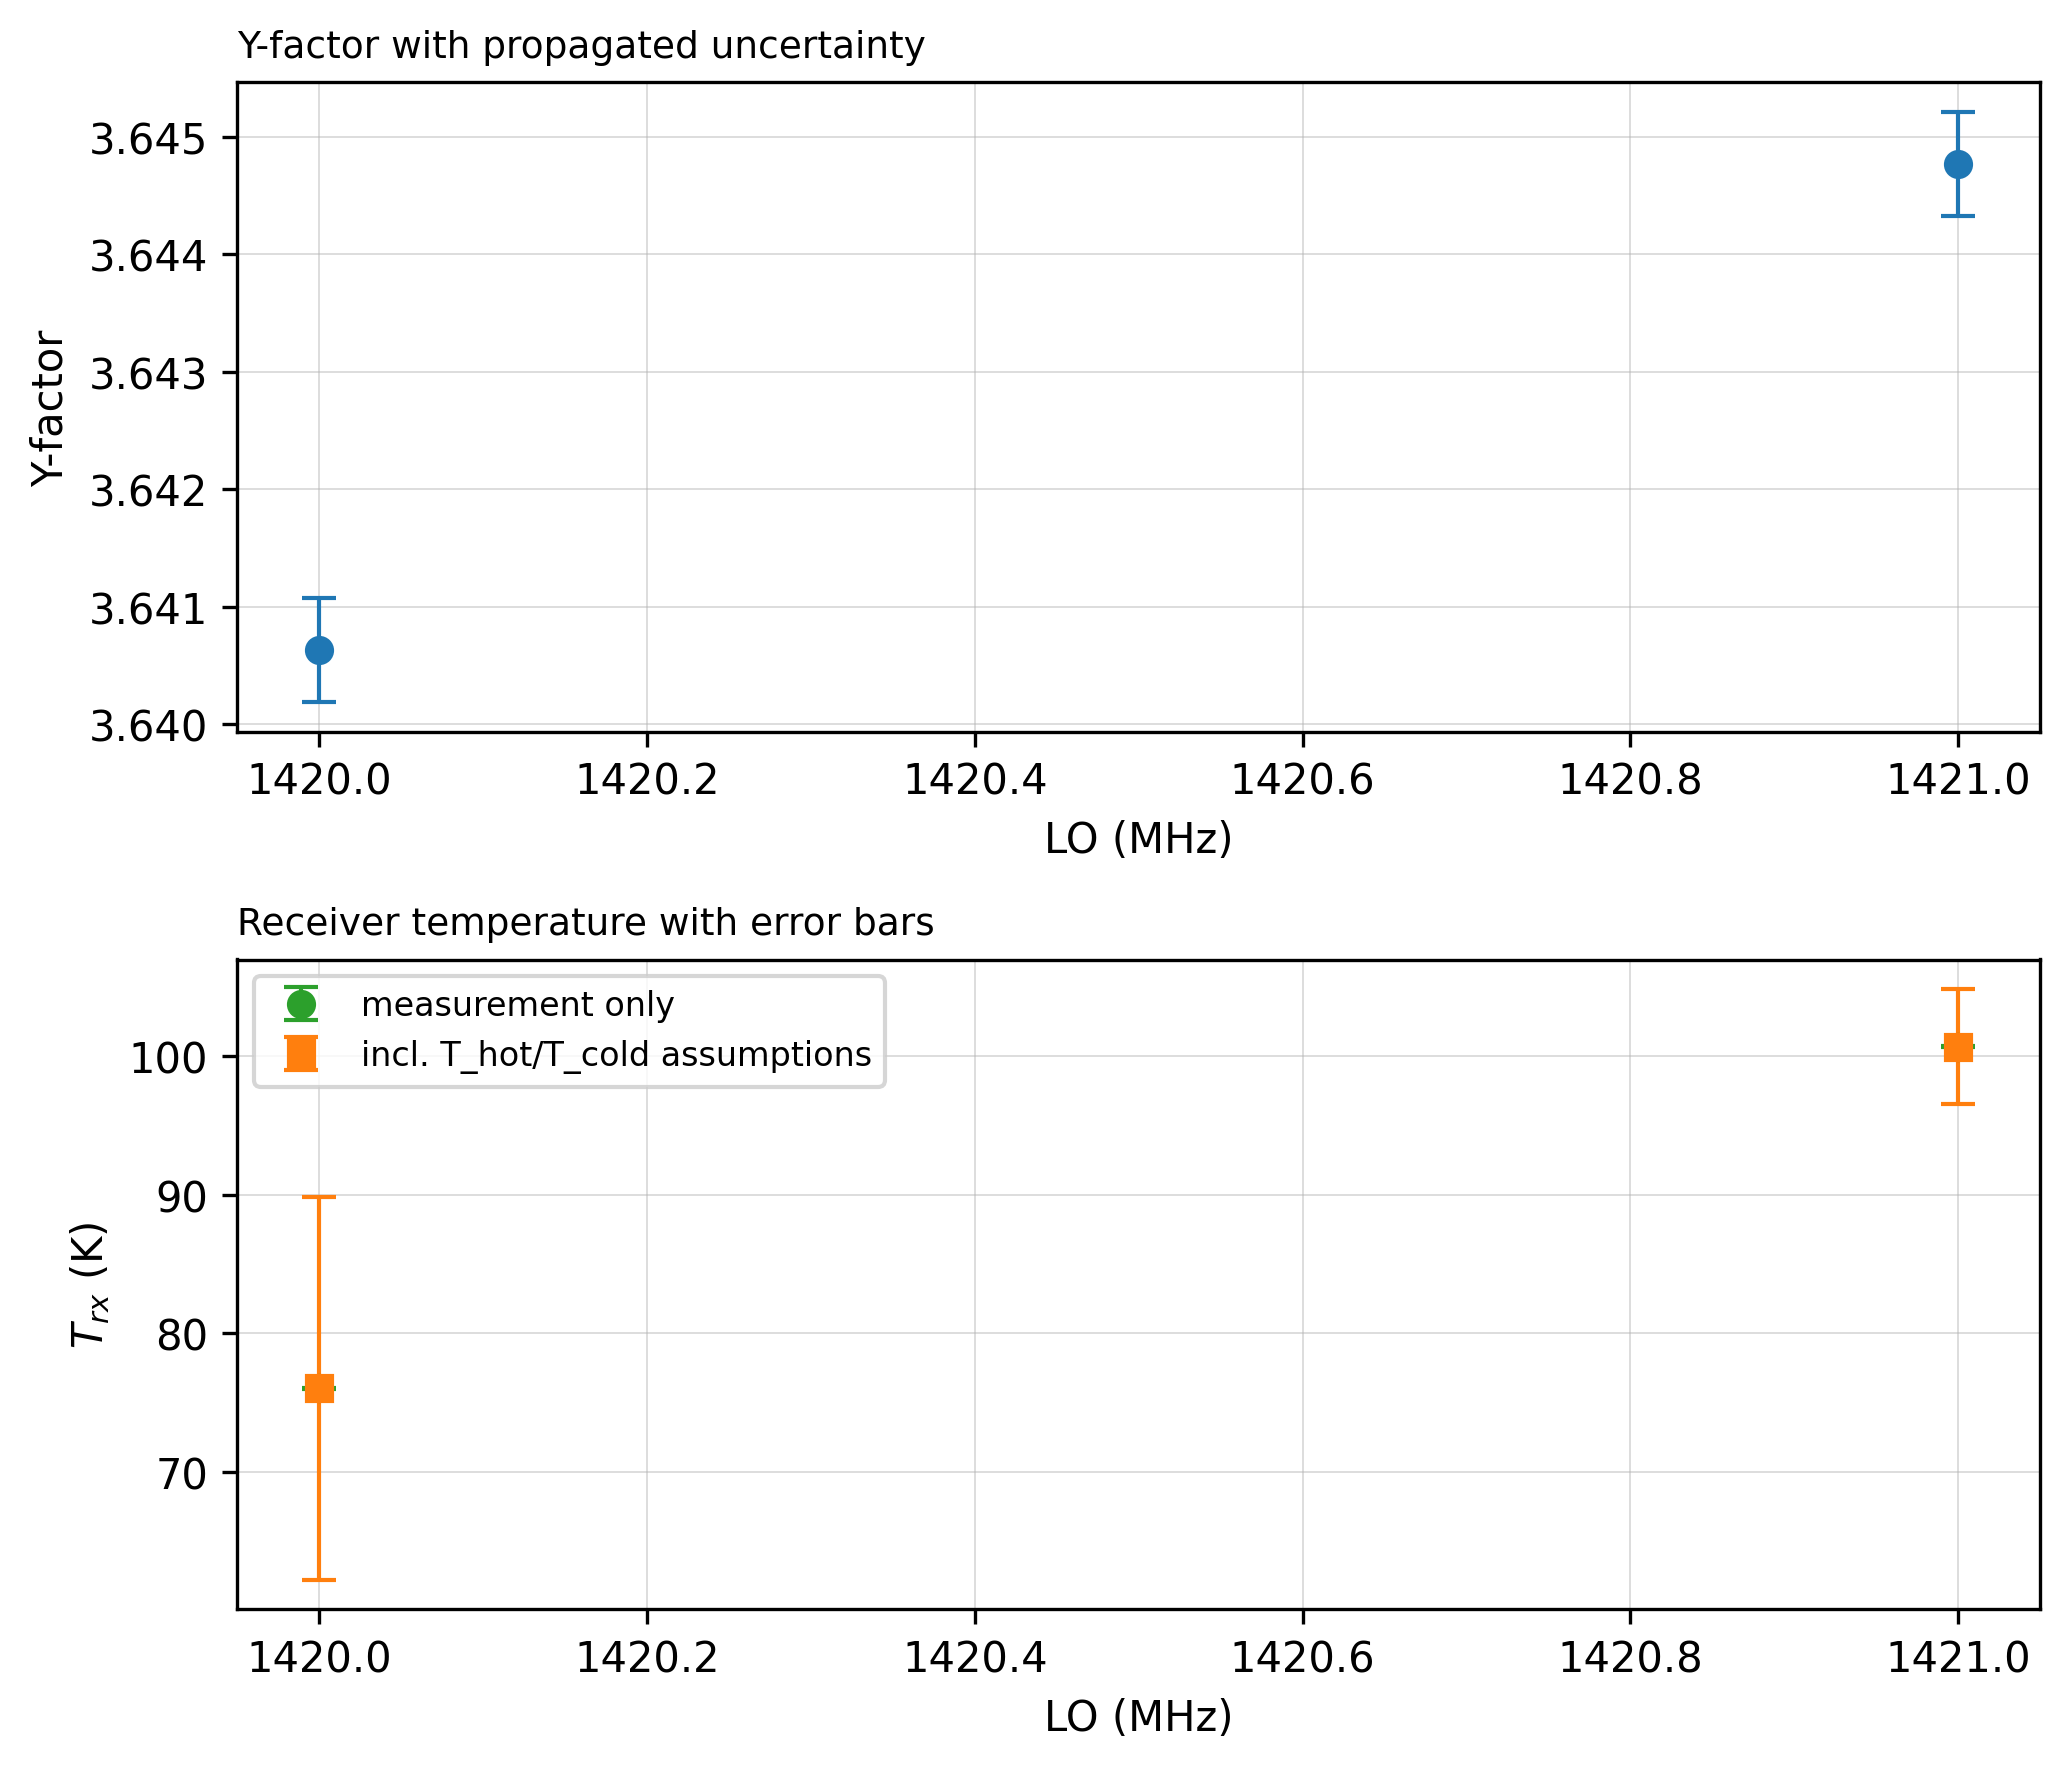

In [15]:
# Y-factor and T_rx with propagated error bars
TARGET_LOS_HZ = [1420e6, 1421e6]
LO_TOL_HZ = 0.5e6

HUMAN_DIR = os.path.join(DATA_ROOT, 'human_combined')
LOW_HI_DIR = os.path.join(DATA_ROOT, 'low-hi_combined')

if 'human_spectra' in globals() and len(human_spectra) > 0:
    hot_spectra = sorted(human_spectra, key=lambda s: s.center_freq)
else:
    hot_spectra = load_or_process(HUMAN_DIR)
    hot_spectra.sort(key=lambda s: s.center_freq)

if 'low_hi_spectra' in globals() and len(low_hi_spectra) > 0:
    cold_spectra = sorted(low_hi_spectra, key=lambda s: s.center_freq)
else:
    cold_spectra = load_or_process(LOW_HI_DIR)
    cold_spectra.sort(key=lambda s: s.center_freq)

def pick_by_lo(spectra, lo_hz, tol_hz=LO_TOL_HZ):
    matches = [s for s in spectra if abs(s.center_freq - lo_hz) < tol_hz]
    if not matches:
        raise ValueError(f'No spectrum found near LO={lo_hz/1e6:.0f} MHz')
    return min(matches, key=lambda s: abs(s.center_freq - lo_hz))

def sigma_total_power(spec):
    # spec.std is average per-bin SEM of PSD; propagate to sum over bins
    return float(np.sqrt(spec.psd.size) * spec.std)

# Temperature assumptions (edit as needed)
T_HOT_K = 310.0
SIGMA_T_HOT_K = 1.0
T_COLD_K = {1420: 30.0, 1421: 12.0}
SIGMA_T_COLD_K = {1420: 10.0, 1421: 3.0}

rows = []
for lo_hz in TARGET_LOS_HZ:
    lo_mhz = int(round(lo_hz / 1e6))
    hot = pick_by_lo(hot_spectra, lo_hz)
    cold = pick_by_lo(cold_spectra, lo_hz)

    p_hot = float(hot.total_power)
    p_cold = float(cold.total_power)
    sigma_p_hot = sigma_total_power(hot)
    sigma_p_cold = sigma_total_power(cold)

    y = p_hot / p_cold
    sigma_y = y * np.sqrt((sigma_p_hot / p_hot) ** 2 + (sigma_p_cold / p_cold) ** 2)
    y_db = 10.0 * np.log10(y)
    sigma_y_db = (10.0 / np.log(10.0)) * (sigma_y / y)

    t_cold = T_COLD_K[lo_mhz]
    sigma_t_cold = SIGMA_T_COLD_K[lo_mhz]
    t_rx = (T_HOT_K - y * t_cold) / (y - 1.0)

    # Error propagation for T_rx(y, T_hot, T_cold)
    d_tdy = (t_cold - T_HOT_K) / (y - 1.0) ** 2
    d_tdth = 1.0 / (y - 1.0)
    d_tdtc = -y / (y - 1.0)

    sigma_t_rx_meas = abs(d_tdy) * sigma_y
    sigma_t_rx_total = np.sqrt(
        (d_tdy * sigma_y) ** 2
        + (d_tdth * SIGMA_T_HOT_K) ** 2
        + (d_tdtc * sigma_t_cold) ** 2
    )

    rows.append({
        'LO_MHz': lo_mhz,
        'P_hot': p_hot,
        'sigma_P_hot': sigma_p_hot,
        'P_cold': p_cold,
        'sigma_P_cold': sigma_p_cold,
        'Y': y,
        'sigma_Y': sigma_y,
        'Y_dB': y_db,
        'sigma_Y_dB': sigma_y_db,
        'T_rx_K': t_rx,
        'sigma_T_rx_meas_K': sigma_t_rx_meas,
        'sigma_T_rx_total_K': sigma_t_rx_total,
        'T_hot_K': T_HOT_K,
        'sigma_T_hot_K': SIGMA_T_HOT_K,
        'T_cold_K': t_cold,
        'sigma_T_cold_K': sigma_t_cold,
    })

print('Y-factor and T_rx summary')
print('-' * 128)
print(' LO    P_hot ± sigma      P_cold ± sigma      Y ± sigma (dB)          T_rx ± sigma_meas ± sigma_total [K]')
print('-' * 128)
for r in rows:
    print(
        f" {r['LO_MHz']:4d}  "
        f"{r['P_hot']:.6f} ± {r['sigma_P_hot']:.6f}  "
        f"{r['P_cold']:.6f} ± {r['sigma_P_cold']:.6f}  "
        f"{r['Y']:.6f} ± {r['sigma_Y']:.6f} ({r['Y_dB']:.4f} ± {r['sigma_Y_dB']:.4f} dB)  "
        f"{r['T_rx_K']:.3f} ± {r['sigma_T_rx_meas_K']:.3f} ± {r['sigma_T_rx_total_K']:.3f}"
    )

los = np.array([r['LO_MHz'] for r in rows], dtype=float)
y_vals = np.array([r['Y'] for r in rows], dtype=float)
y_err = np.array([r['sigma_Y'] for r in rows], dtype=float)
trx_vals = np.array([r['T_rx_K'] for r in rows], dtype=float)
trx_err_meas = np.array([r['sigma_T_rx_meas_K'] for r in rows], dtype=float)
trx_err_total = np.array([r['sigma_T_rx_total_K'] for r in rows], dtype=float)

fig, axes = plt.subplots(2, 1, figsize=(7, 6), dpi=300)

axes[0].errorbar(los, y_vals, yerr=y_err, fmt='o', capsize=4, lw=1.0, color='C0')
axes[0].set_xlabel('LO (MHz)')
axes[0].set_ylabel('Y-factor')
axes[0].set_title('Y-factor with propagated uncertainty', fontsize=9, loc='left')
axes[0].grid(True, lw=0.4, alpha=0.5)

axes[1].errorbar(los, trx_vals, yerr=trx_err_meas, fmt='o', capsize=4, lw=1.0, color='C2', label='measurement only')
axes[1].errorbar(los, trx_vals, yerr=trx_err_total, fmt='s', capsize=4, lw=1.0, color='C1', label='incl. T_hot/T_cold assumptions')
axes[1].set_xlabel('LO (MHz)')
axes[1].set_ylabel(r'$T_{rx}$ (K)')
axes[1].set_title('Receiver temperature with error bars', fontsize=9, loc='left')
axes[1].legend(fontsize=8)
axes[1].grid(True, lw=0.4, alpha=0.5)

fig.tight_layout()
plt.show()
